Use a subset of data to run a small registration example.

In [1]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import os


# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [2]:
# todo list in this cell
# explicitly write out forward and inverse transforms instead of velocity field
# specifics for 3D to 2D mapping
# apply transforms to new data from command line
# different data types: either preprocess data and convert format, or modify code to support another data type
# reading and writing in other data types: especially nifty nii, I would rely on nibabel to do this

In [3]:
# maybe I want to use the exvivo, not the atlas. that can be a version 2.
atlas_name = '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50_bregma.vtk'
label_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50_bregma.vtk'
atlas_name = '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50.vtk'
label_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50.vtk'
target_name = 'MD787_small_nissl'
config_file = 'config787small.json'
output_dir = '787_small_test_outputs/'


In [4]:
# note about downsampling
# atlas is size 50x50x50
# data is size 14.74*3x14.72*3x200 (i.e. 10 micron, downsampled by a factor of 20)

In [5]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[50. 50. 50.]


<IPython.core.display.Javascript object>


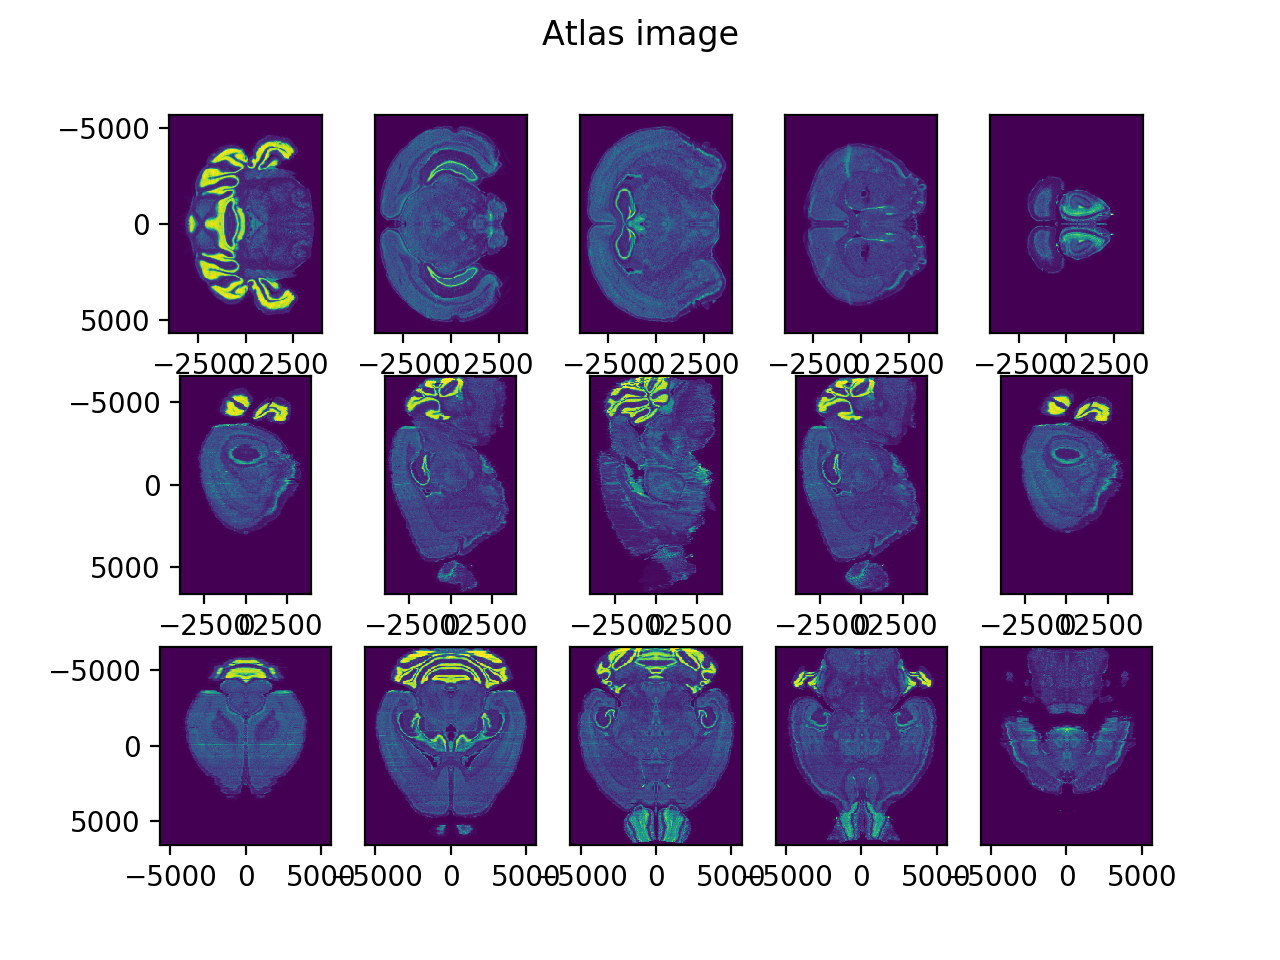

Text(0.5, 0.98, 'Atlas image')

In [6]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

In [7]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[100.0, 100.0, 100.0]


Found extension 
loading target images


<IPython.core.display.Javascript object>


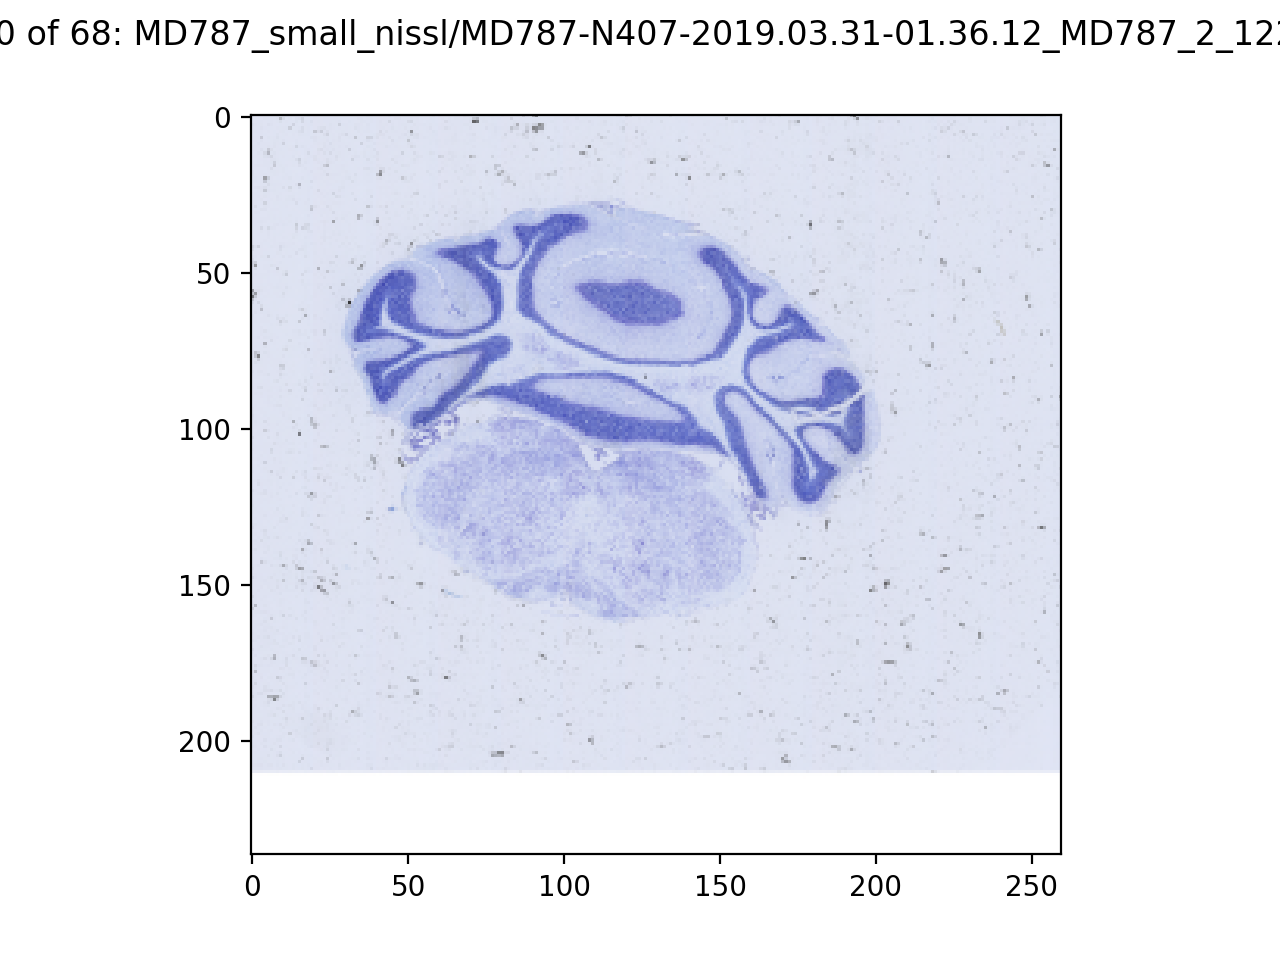

padding and assembling into 3D volume
[200.    44.16  44.16]


<IPython.core.display.Javascript object>


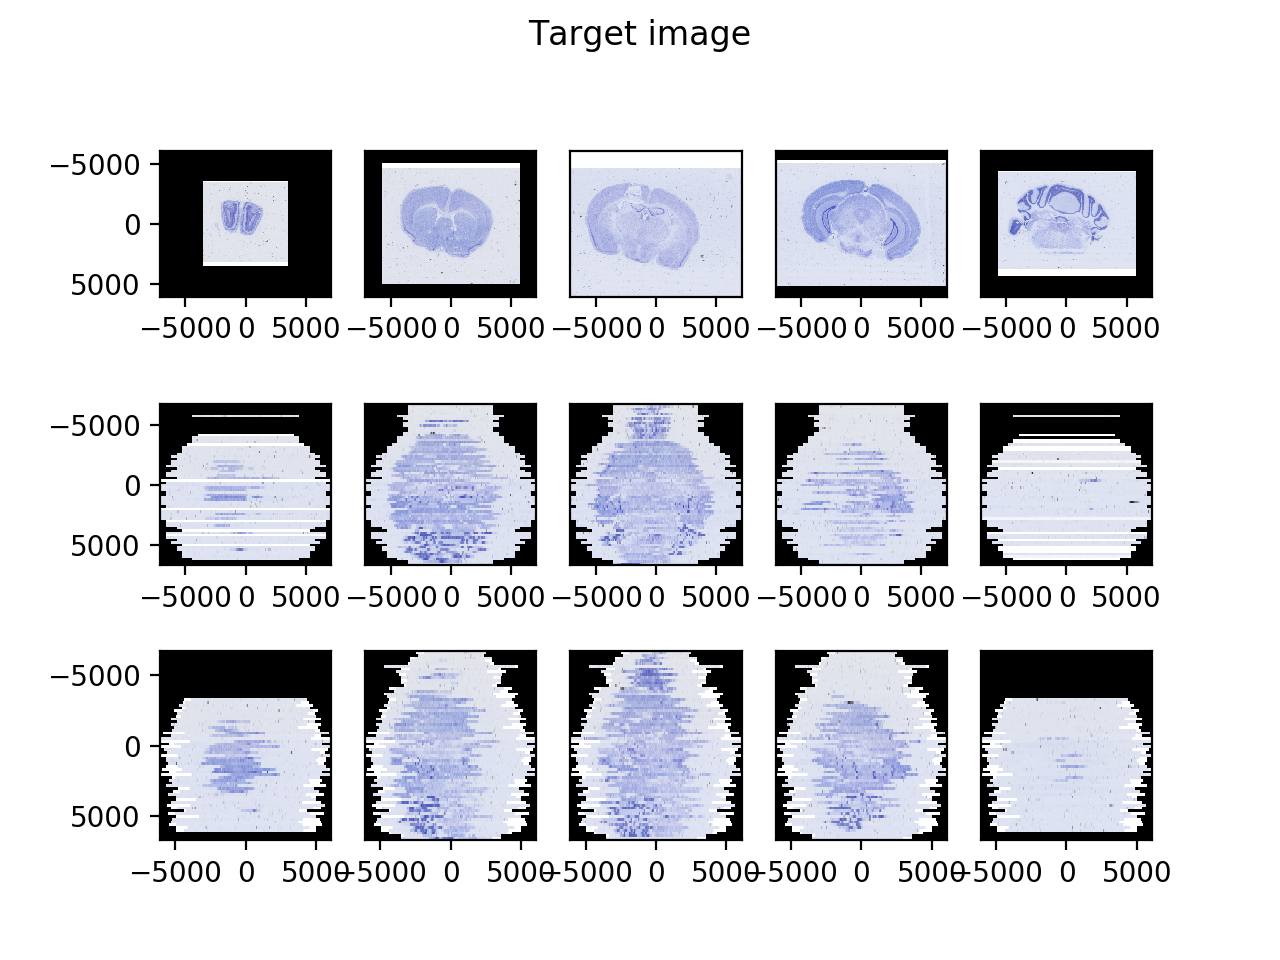

Text(0.5, 0.98, 'Target image')

In [8]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
if 'mask' in names:
    maskind = names.index('mask')
    W0 = J[maskind]
    J = J[np.arange(J.shape[0])!=maskind]    
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')


<IPython.core.display.Javascript object>


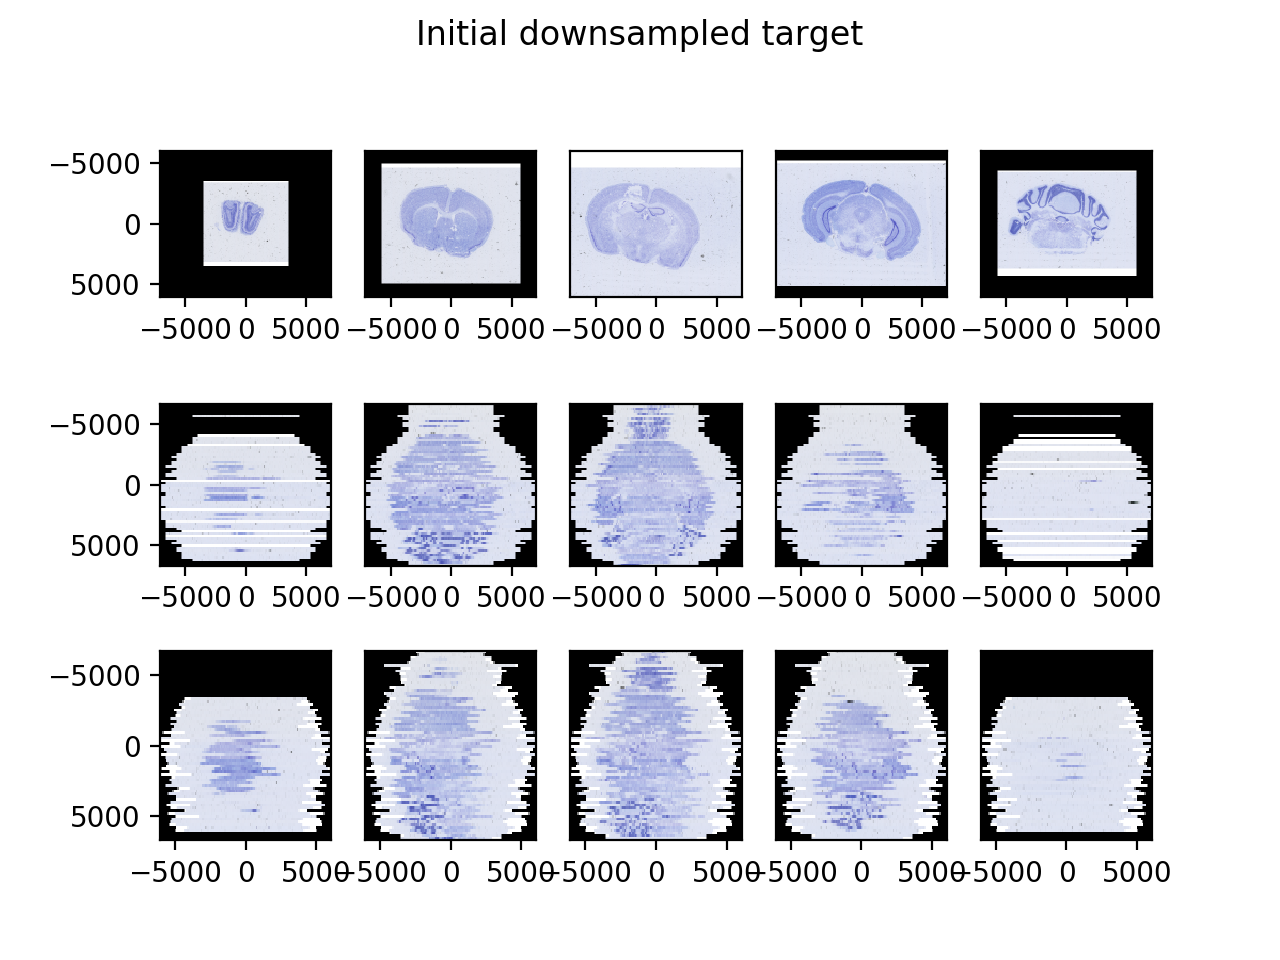

Text(0.5, 0.98, 'Initial downsampled target')

In [9]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')


<IPython.core.display.Javascript object>


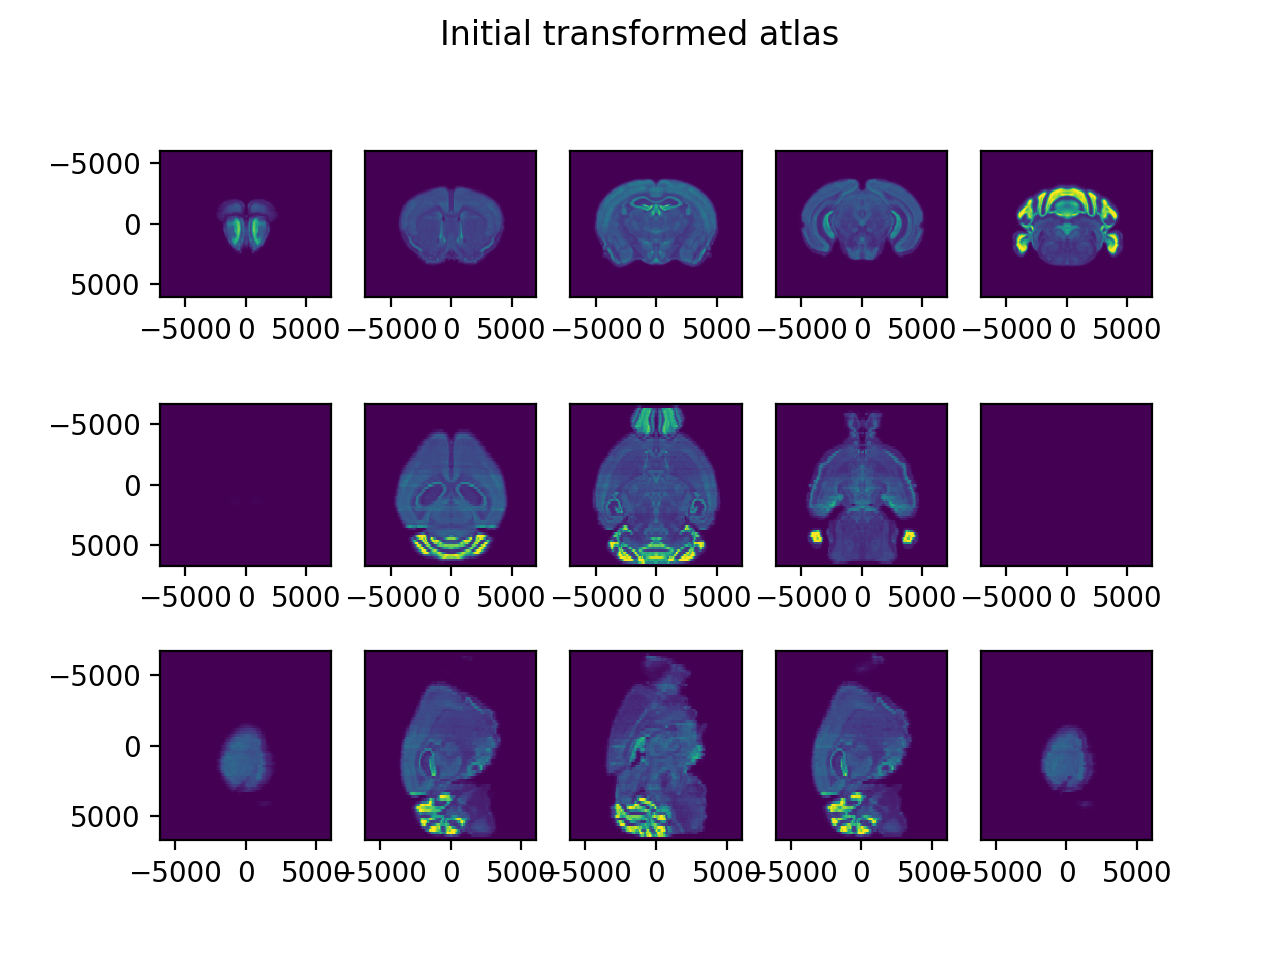

Text(0.5, 0.98, 'Initial transformed atlas')

In [10]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)


# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]
A[:3,-1] = 0
config['A'] = [A]

Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

In [11]:
config

{'n_iter': [1000, 500],
 'downI': [[2, 2, 2], [1, 1, 1]],
 'downJ': [[1, 2, 2], [1, 1, 1]],
 'priors': [[0.9, 0.05, 0.05]],
 'sigmaM': [0.1],
 'sigmaB': [0.2],
 'sigmaA': [0.5],
 'sigmaR': [1000.0],
 'ev': [0.0005],
 'eA': [200000.0, 100000.0],
 'eA2d': [200.0, 50.0],
 'slice_matching': [1],
 'update_muA': [0],
 'update_muB': [0],
 'muA': [[0.1, 0.1, 0.1]],
 'muB': [[0.9, 0.9, 0.9]],
 'update_sigmaM': [0],
 'update_sigmaA': [0],
 'update_sigmaB': [0],
 'order': [3],
 'n_draw': [50],
 'n_e_step': [3],
 'slice_matching_start': [300, 0],
 'v_start': [10000, 0, 0],
 'A': [array([[-1.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.],
         [ 0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  1.]])]}

Found 2 scales
dv tensor([300., 300., 300.], device='cuda:1')
a scale is 600.0


<IPython.core.display.Javascript object>


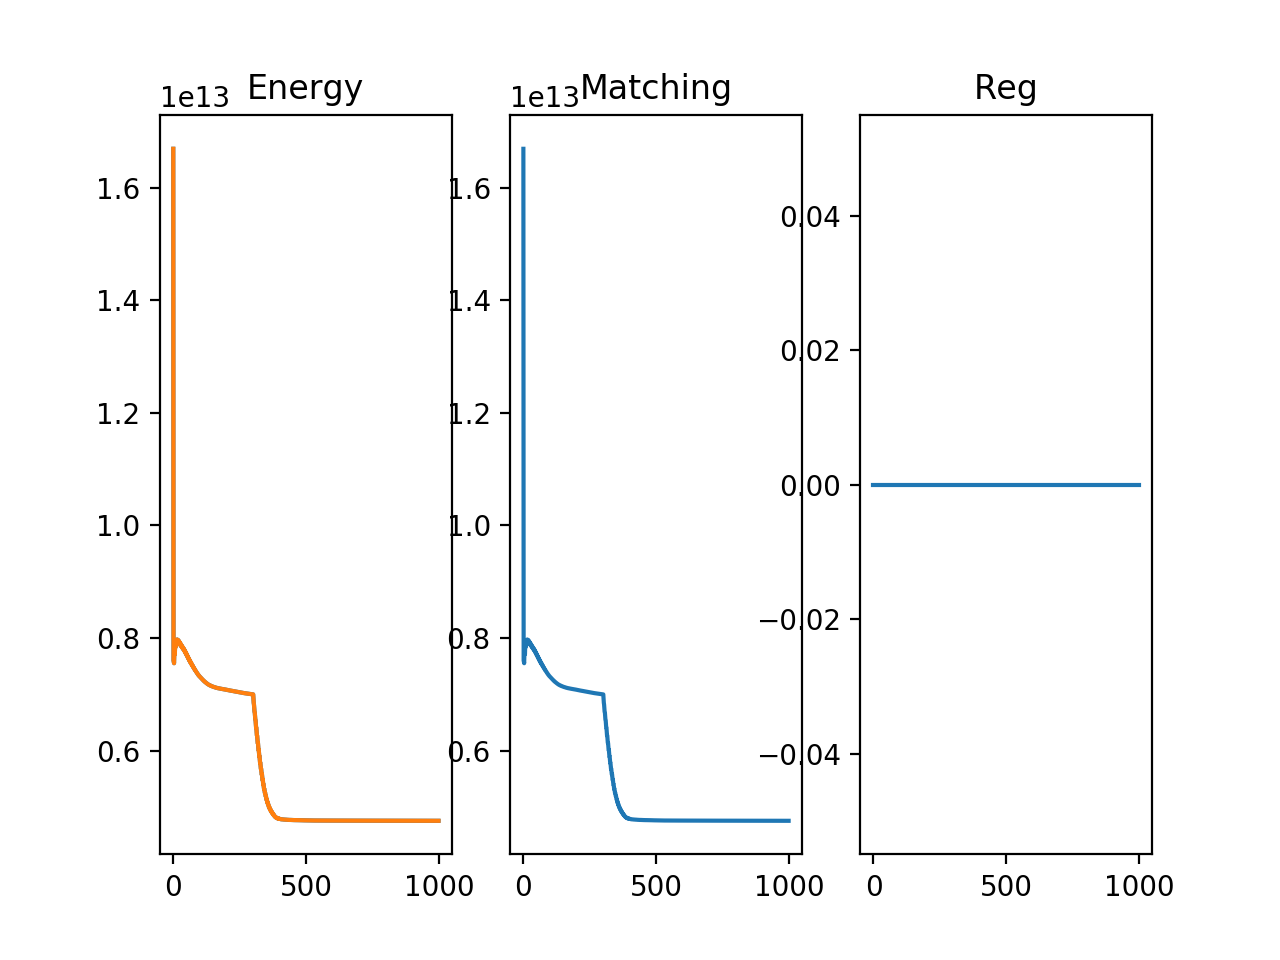

<IPython.core.display.Javascript object>


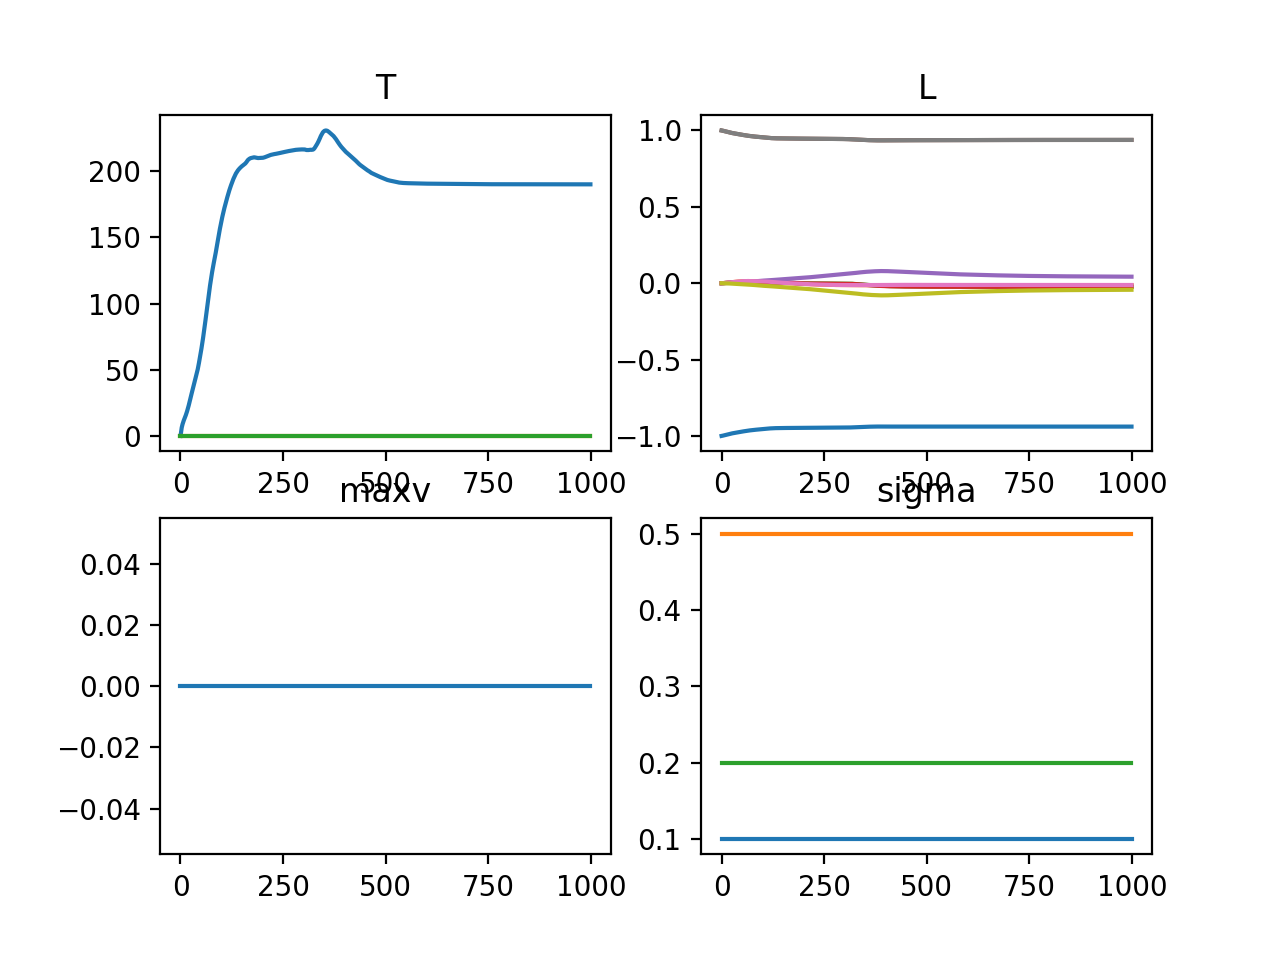

<IPython.core.display.Javascript object>


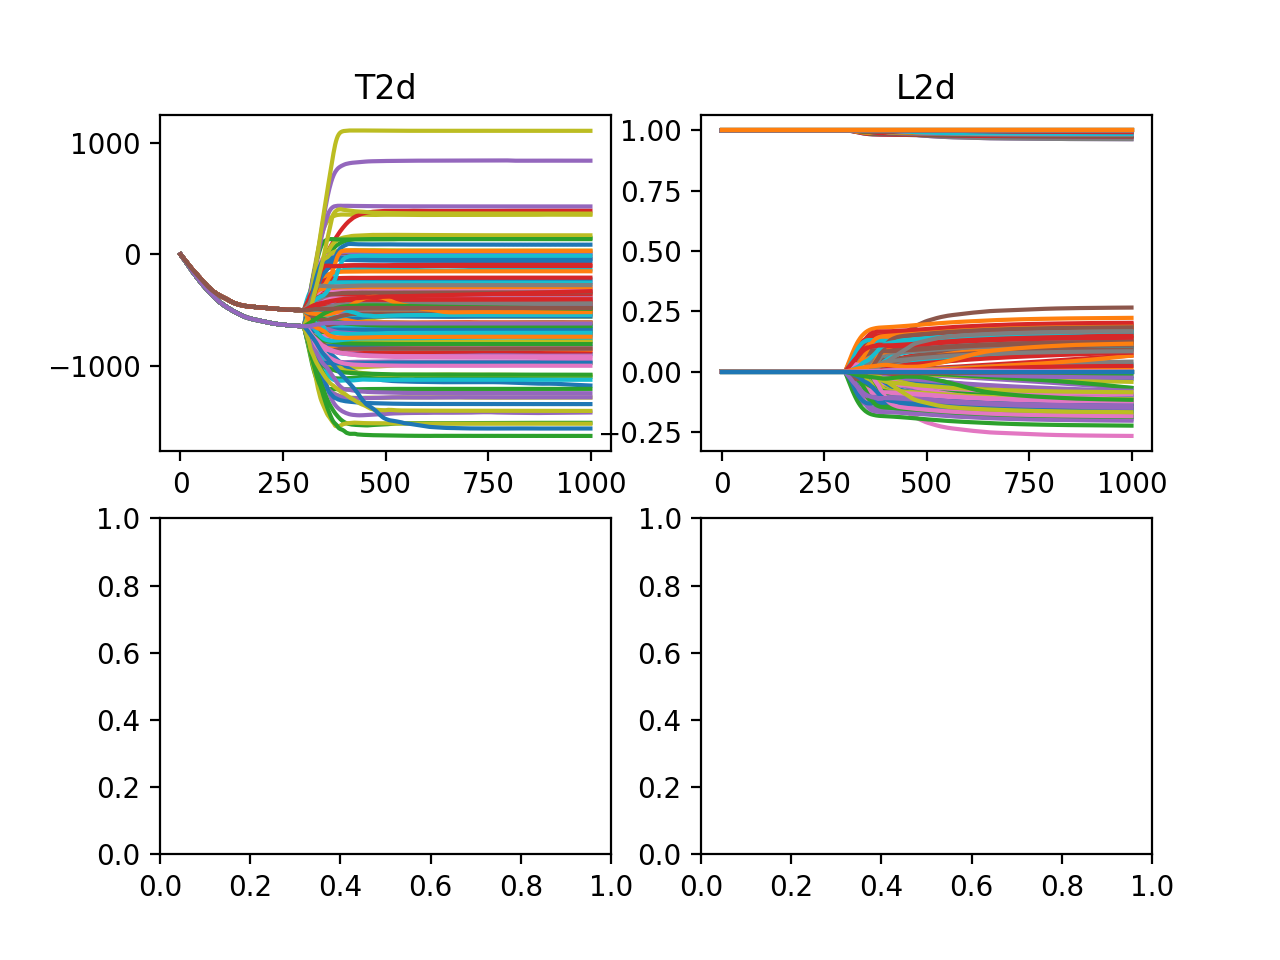

<IPython.core.display.Javascript object>


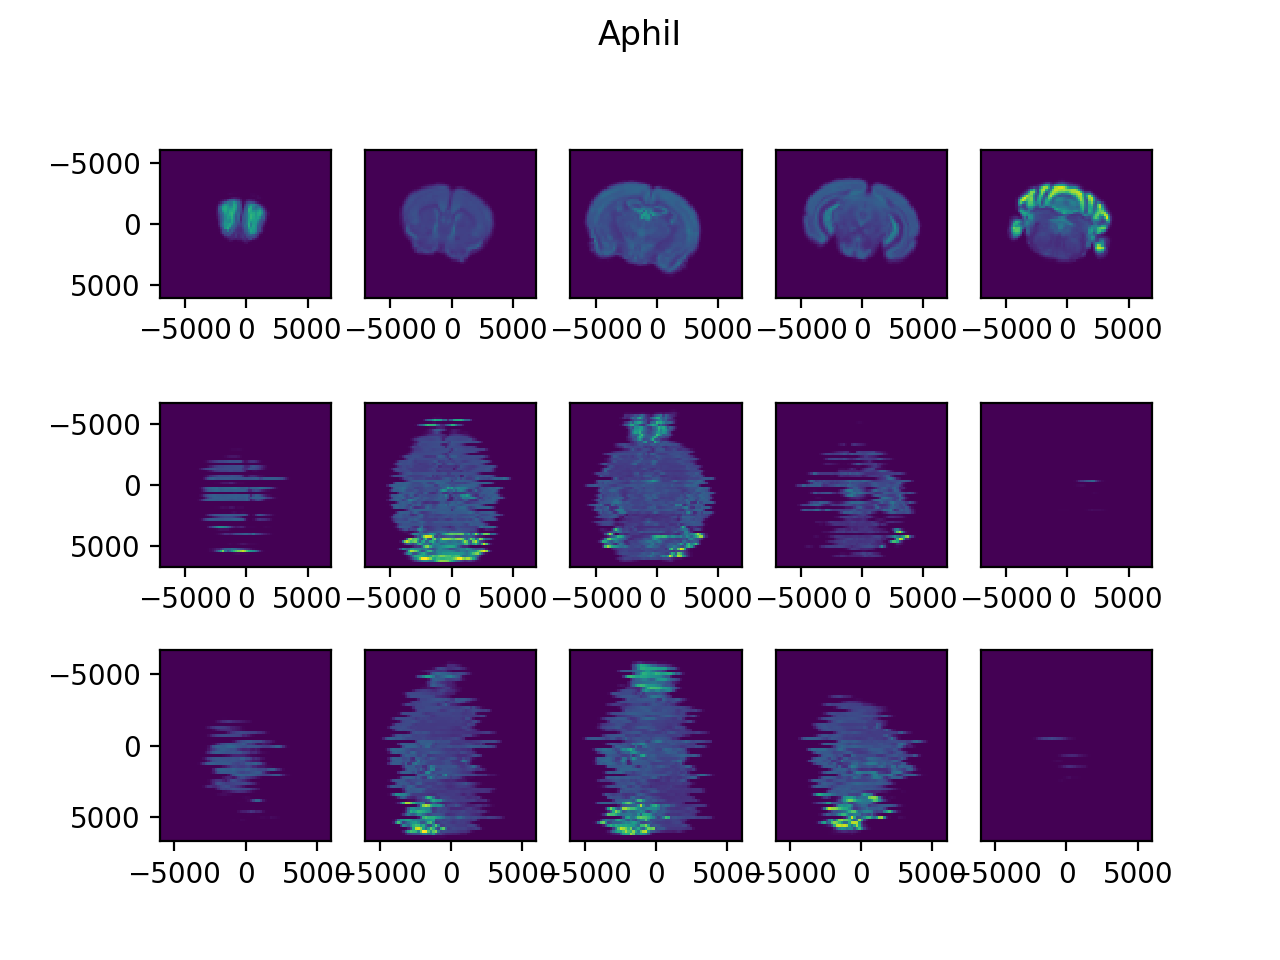

<IPython.core.display.Javascript object>


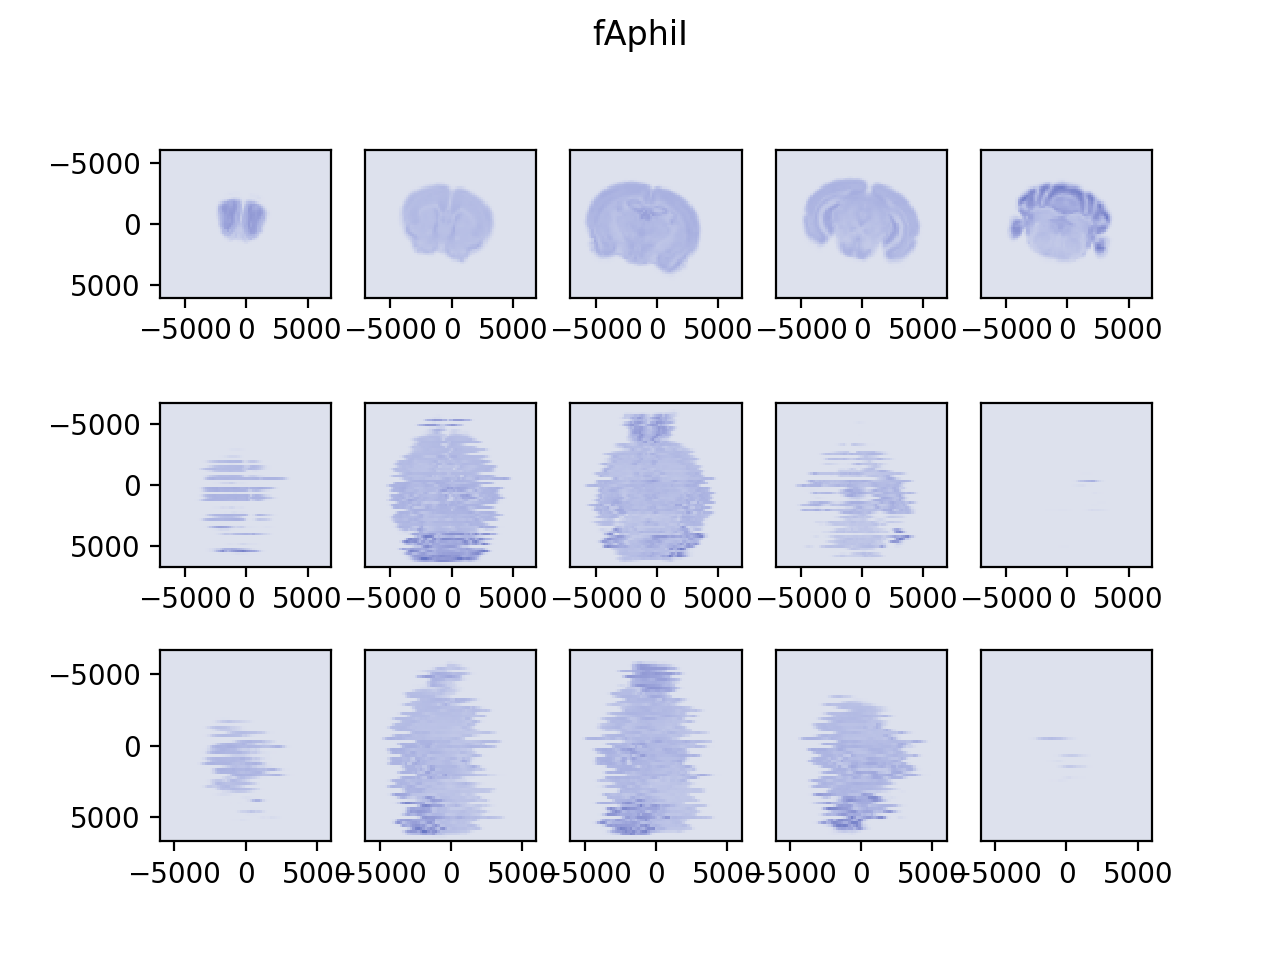

<IPython.core.display.Javascript object>


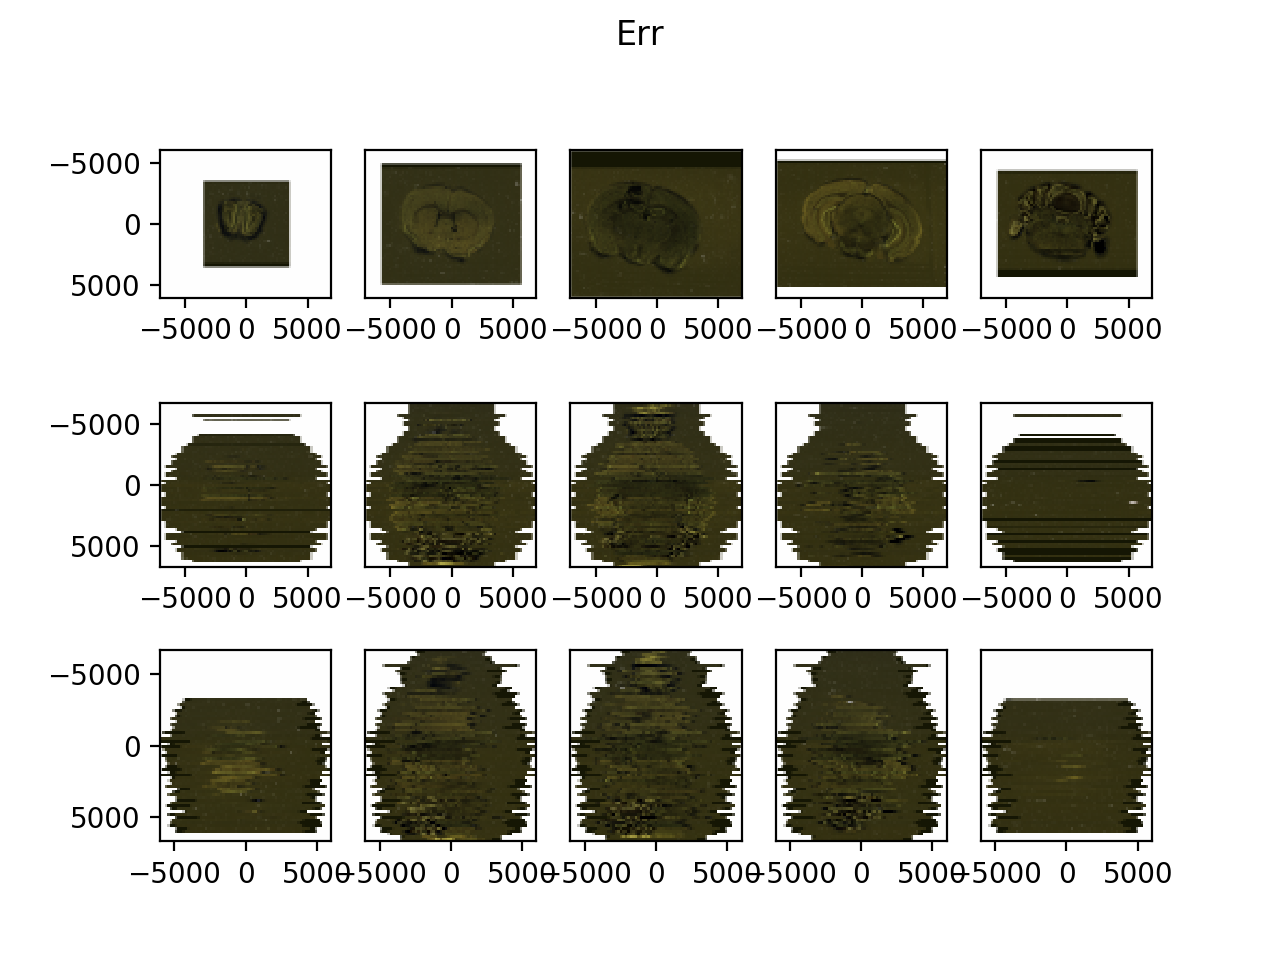

<IPython.core.display.Javascript object>


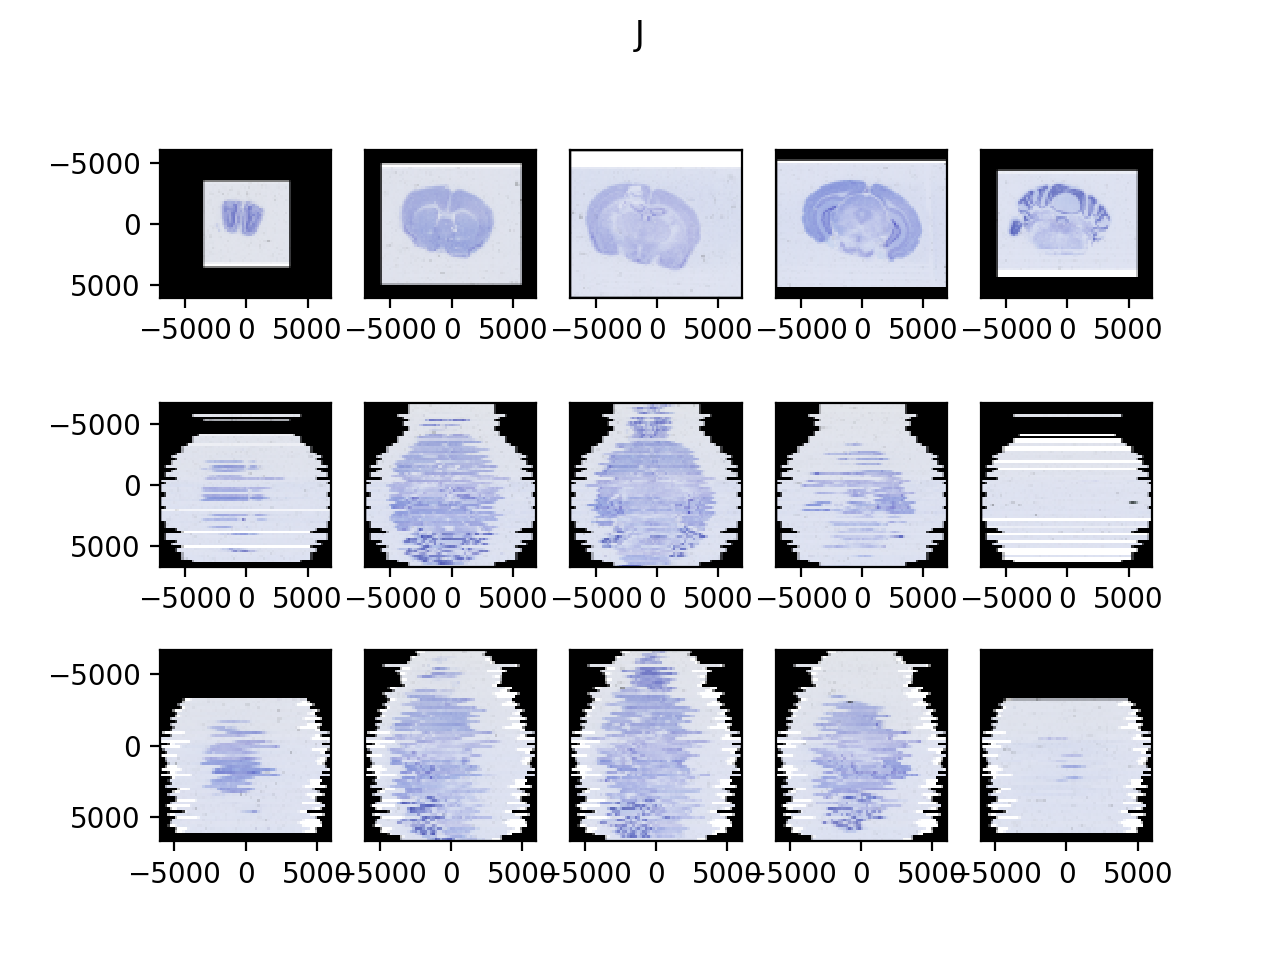

<IPython.core.display.Javascript object>


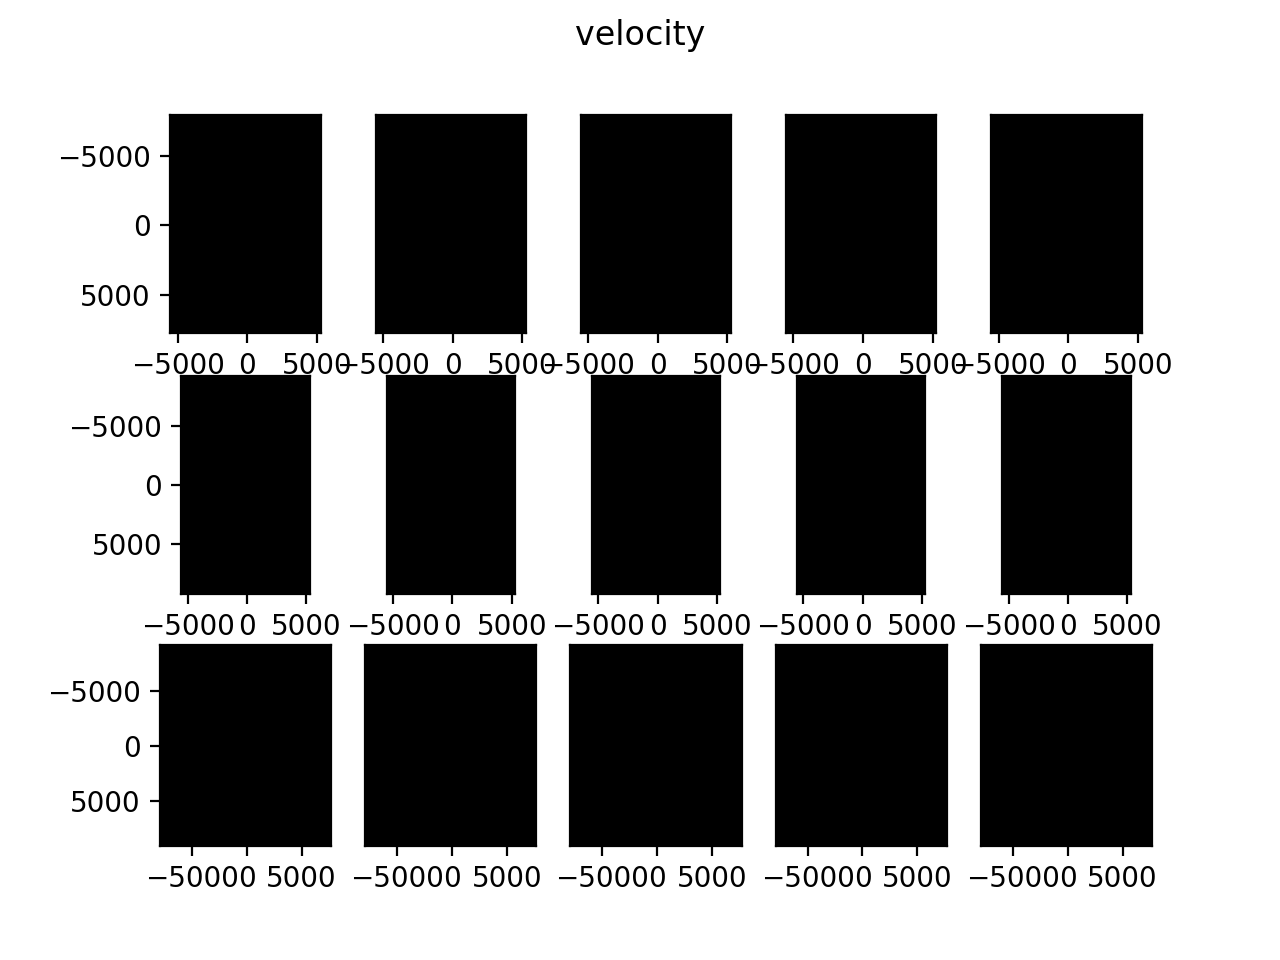

<IPython.core.display.Javascript object>


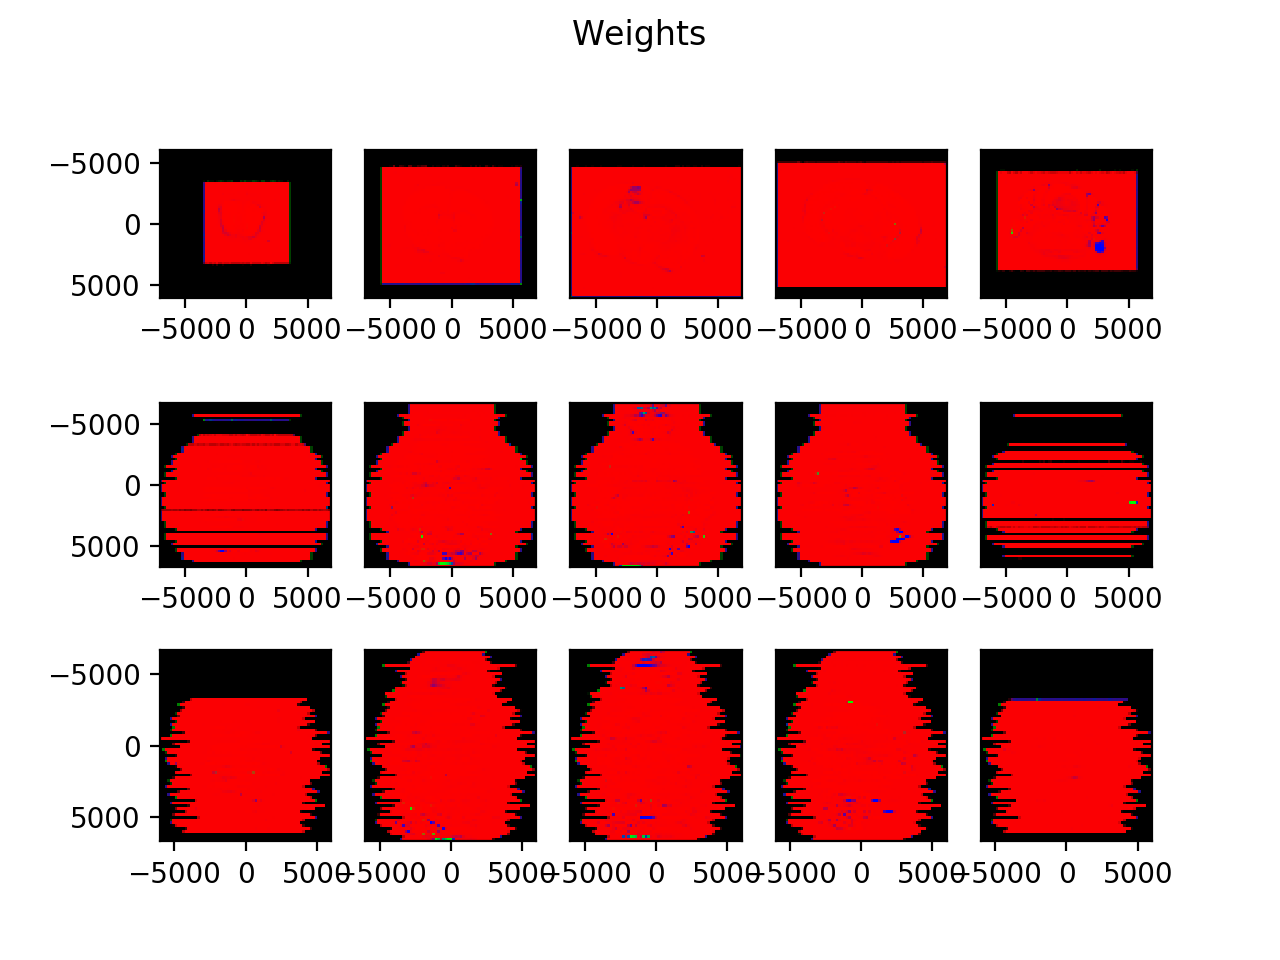

/mnt/data/csh_data/emlddmm/emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
Finished iteration 200
Finished iteration 210
Finished iteration 220
Finished iteration 230
Finished iteration 240
Finished iteration 250
Finished iteration 260
Finished iteration 270
Finished iteration 280
Finished iteration 290
Finished iteration 300
Finished iteration 310
Finished iteration 320
Iteration 330, linear oscilating, reducing eA to 180000.0
Finished iteration 330
Finished iteration 340
Finished iteration 350
Finished iteration 360
Finished iteration 370
Finished iteration 380
Finished iteration 390
Finished iteration 400
Finished i

<IPython.core.display.Javascript object>


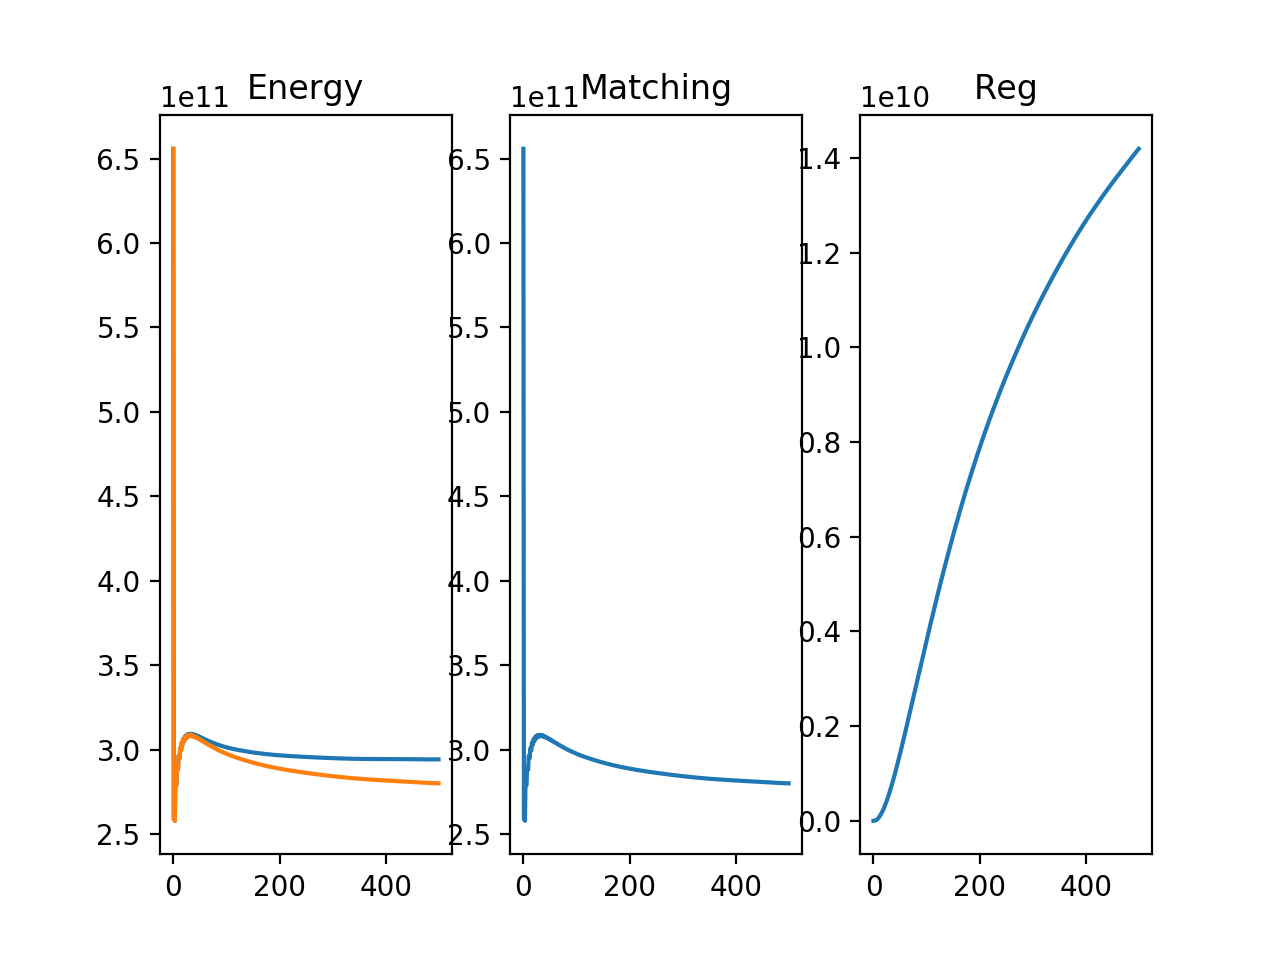

<IPython.core.display.Javascript object>


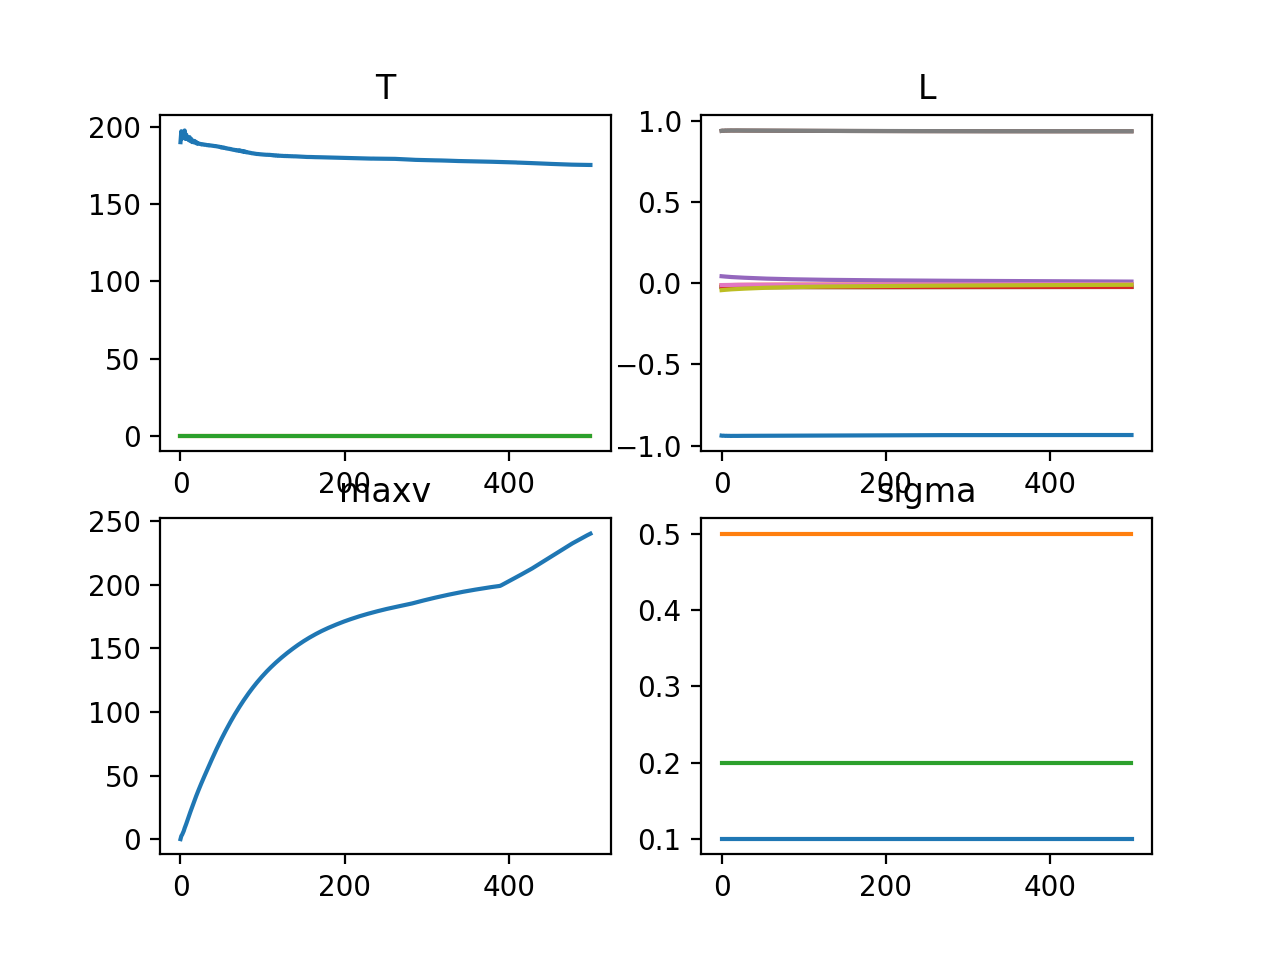

<IPython.core.display.Javascript object>


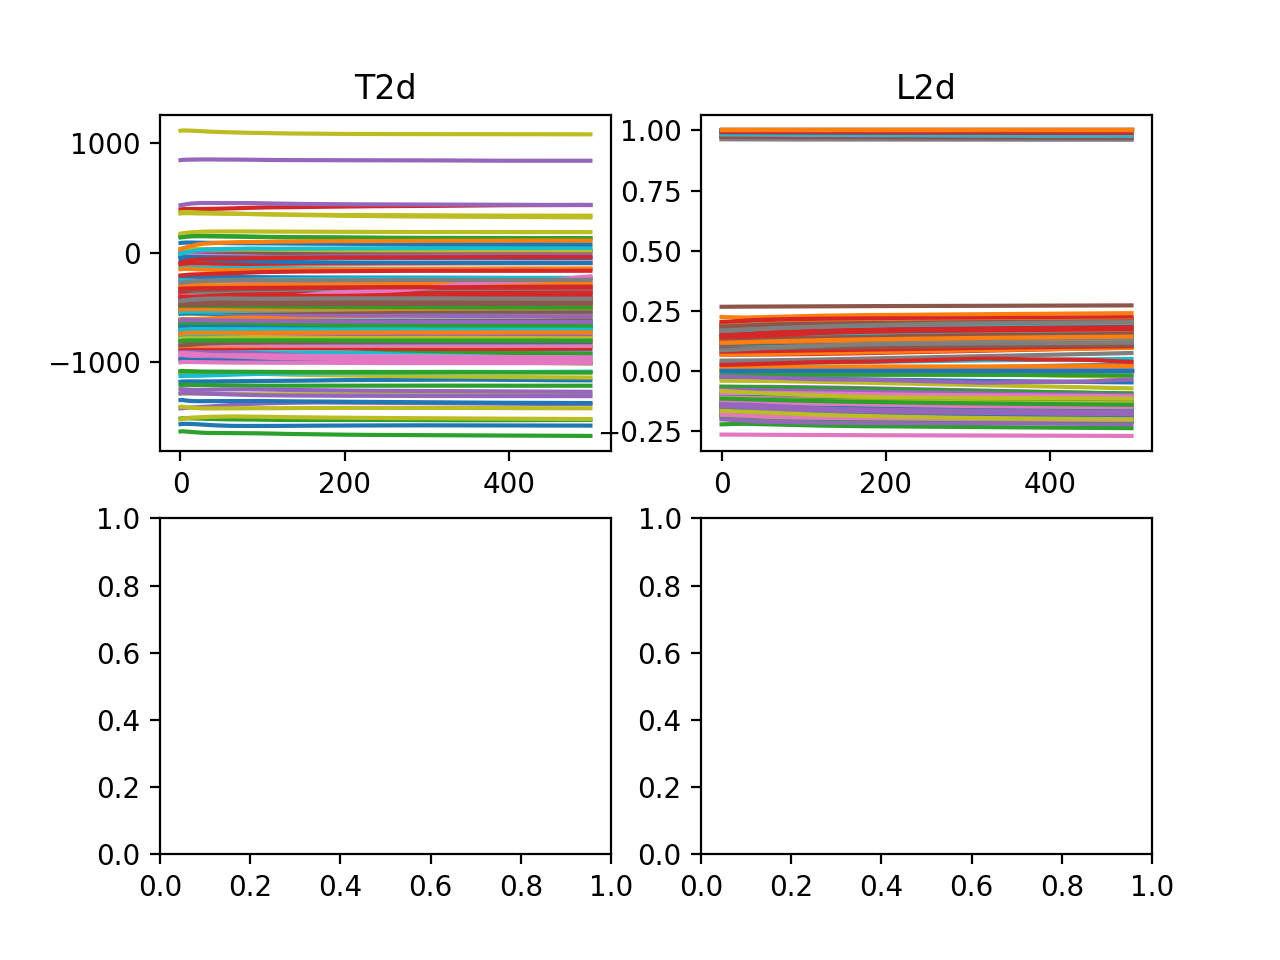

<IPython.core.display.Javascript object>


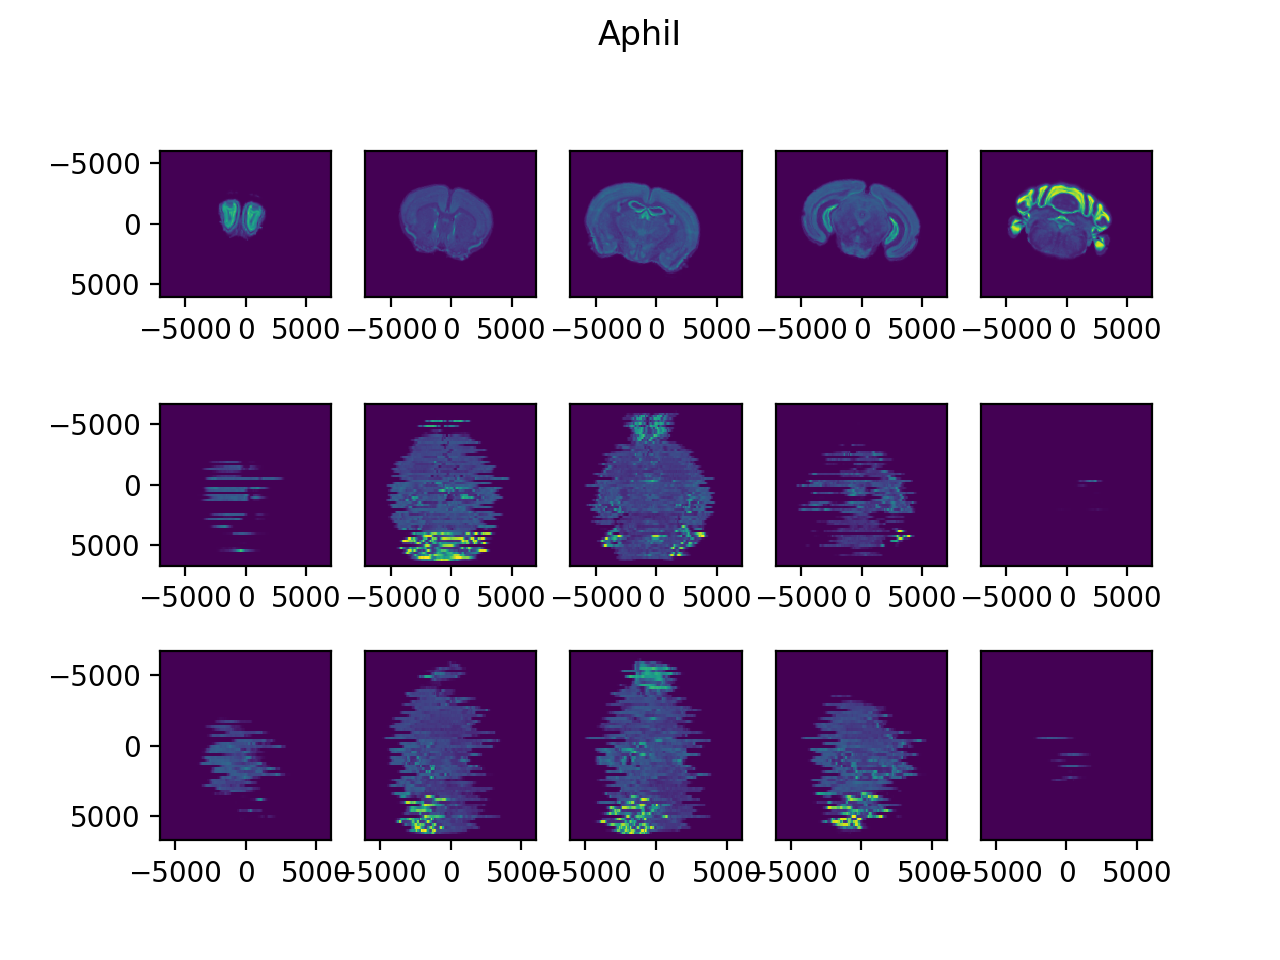

<IPython.core.display.Javascript object>


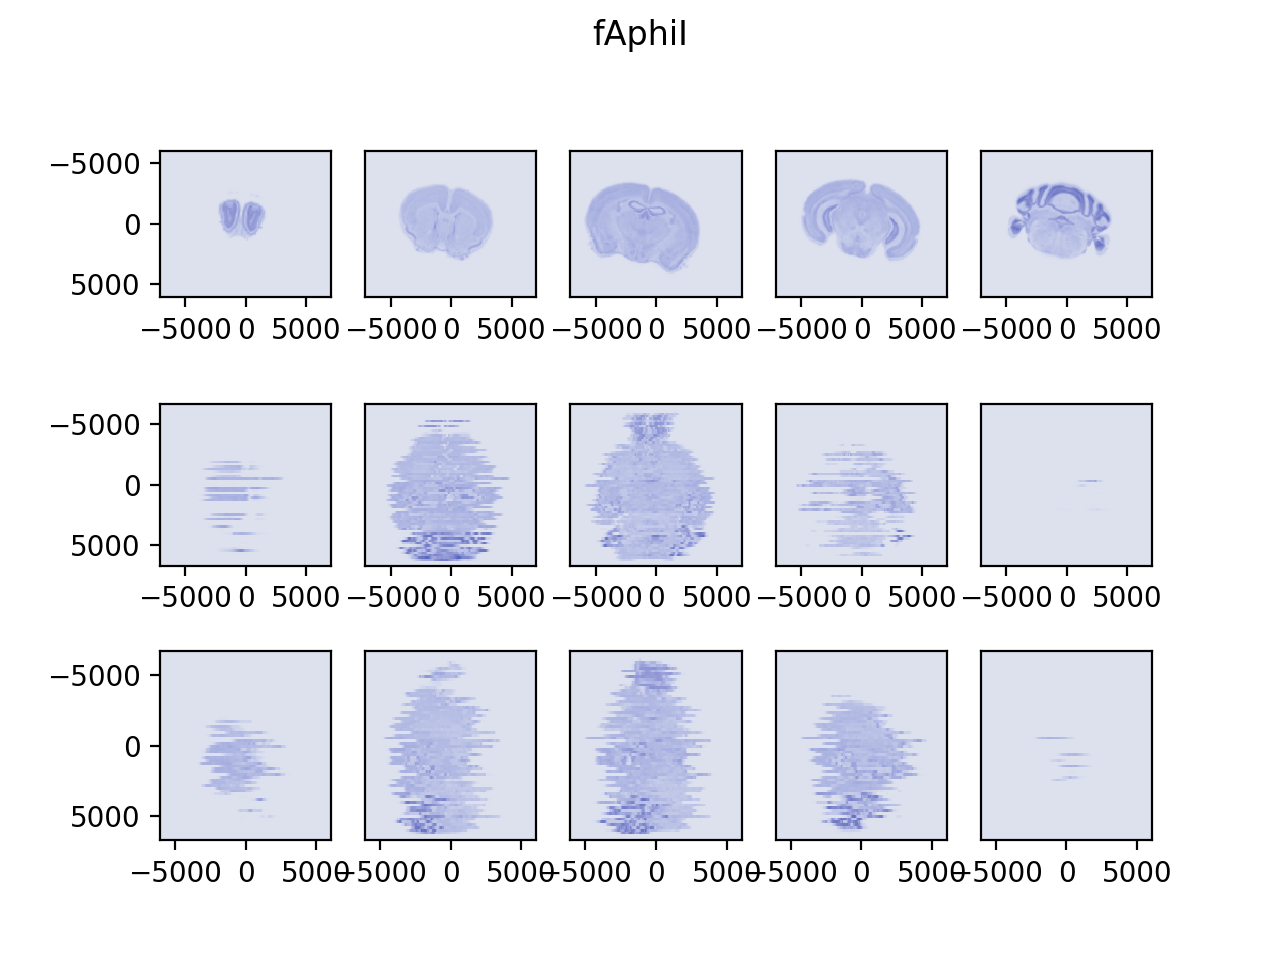

<IPython.core.display.Javascript object>


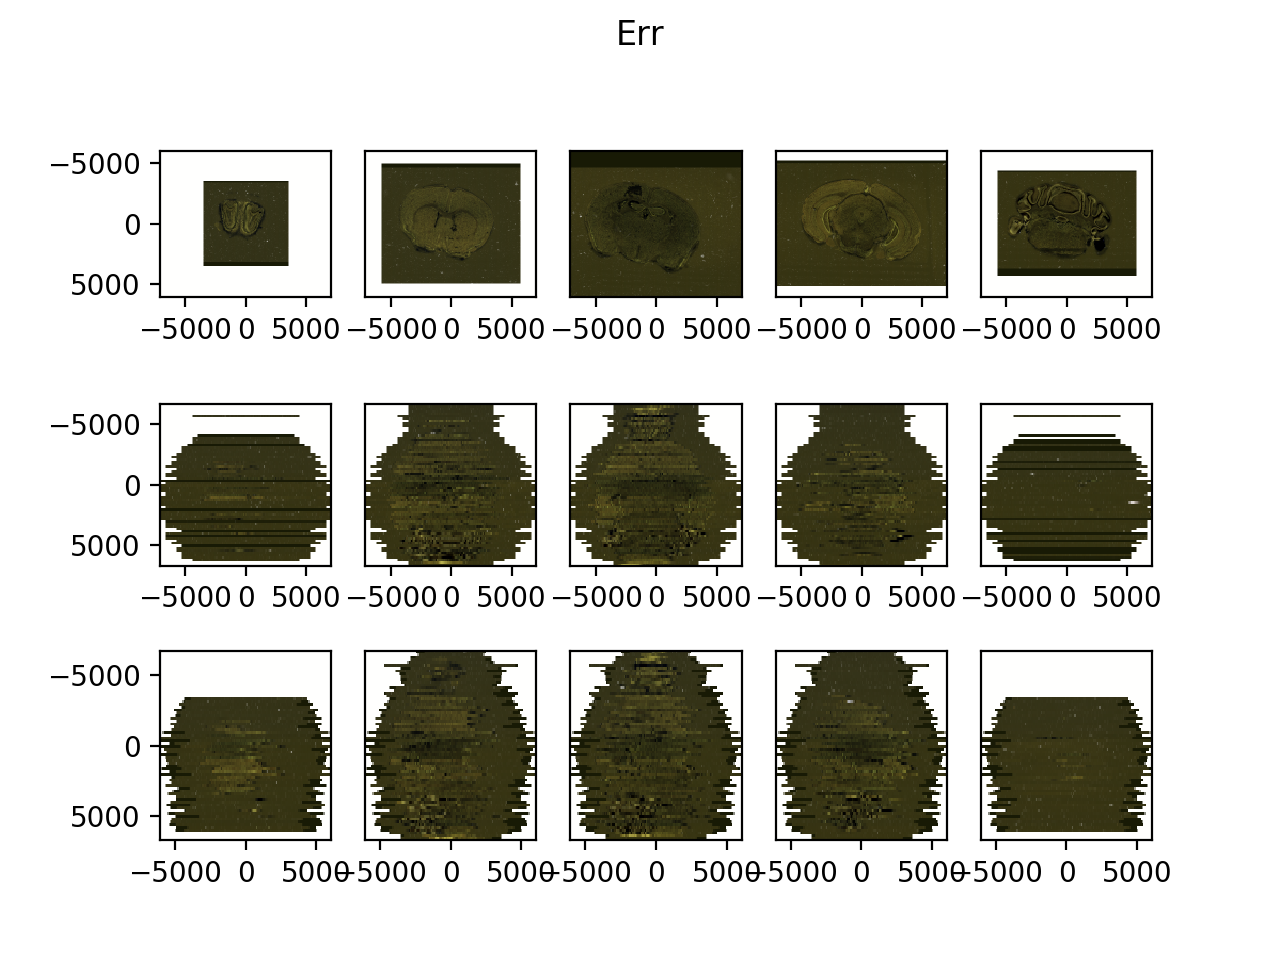

/mnt/data/csh_data/emlddmm/emlddmm.py:872: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figJ = plt.figure()


<IPython.core.display.Javascript object>


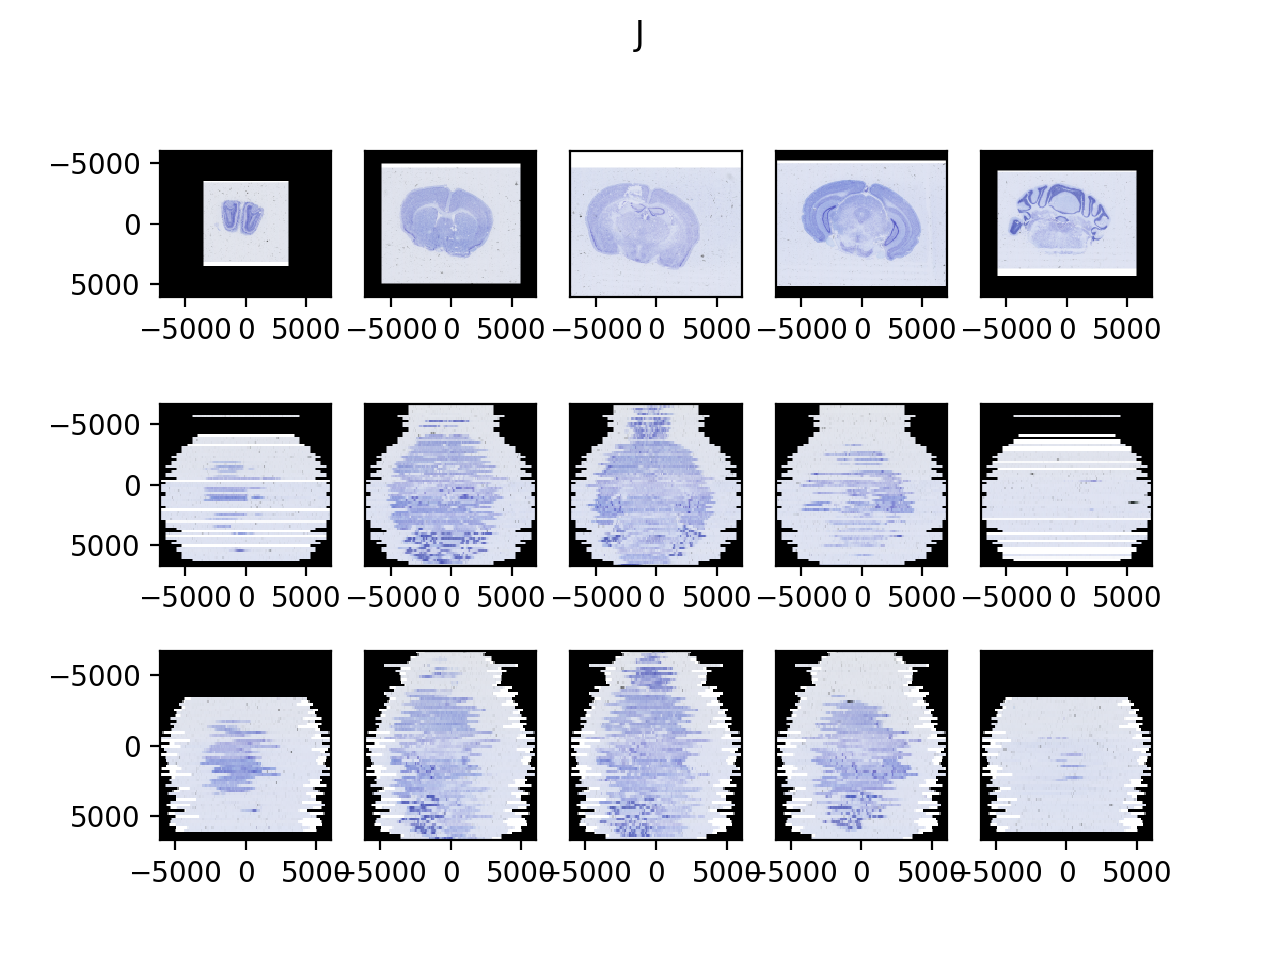

/mnt/data/csh_data/emlddmm/emlddmm.py:873: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figV = plt.figure()


<IPython.core.display.Javascript object>


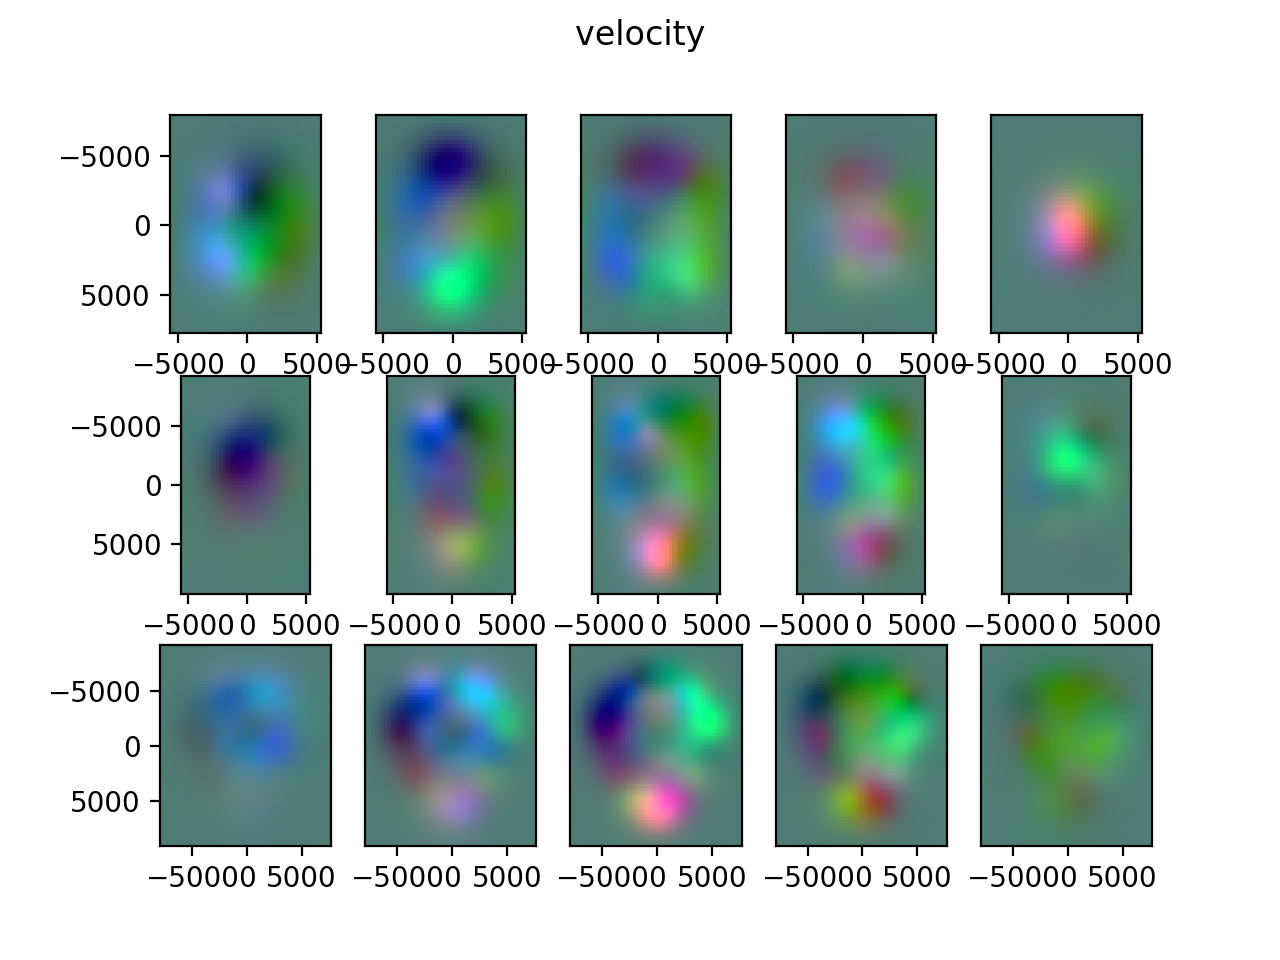

/mnt/data/csh_data/emlddmm/emlddmm.py:874: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figW = plt.figure()


<IPython.core.display.Javascript object>


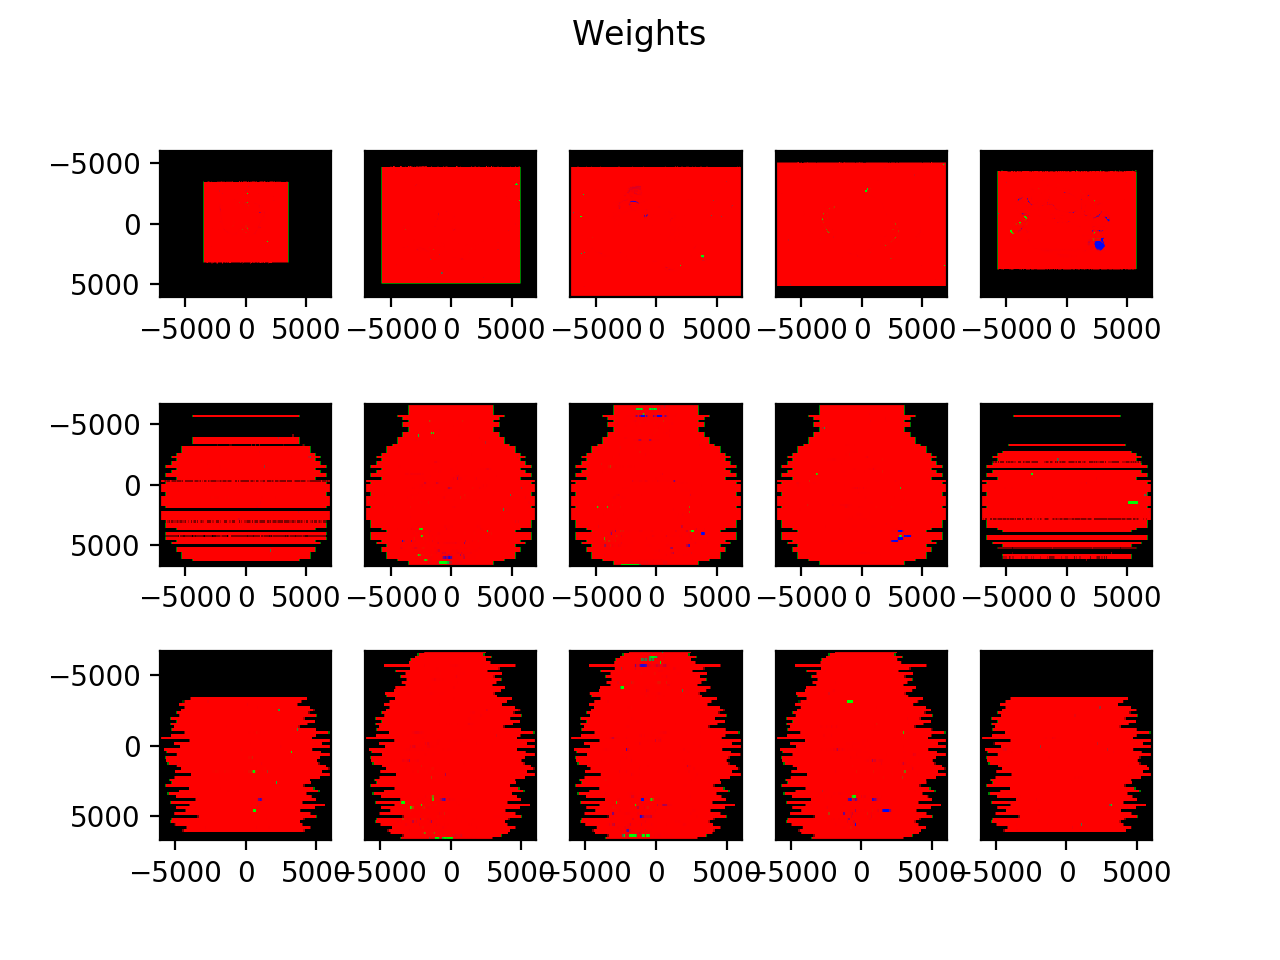

Finished iteration 0
Finished iteration 10
Iteration 20, translation oscilating, reducing eA to 90000.0
Finished iteration 20
Finished iteration 30
Finished iteration 40
Iteration 50, translation oscilating, reducing eA to 81000.0
Finished iteration 50
Finished iteration 60
Iteration 70, translation oscilating, reducing eA to 72900.0
Finished iteration 70
Iteration 80, translation oscilating, reducing eA to 65610.0
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Iteration 120, translation oscilating, reducing eA to 59049.0
Finished iteration 120
Iteration 130, translation oscilating, reducing eA to 53144.1
Finished iteration 130
Finished iteration 140
Iteration 150, linear oscilating, reducing eA to 47829.69
Finished iteration 150
Iteration 160, translation oscilating, reducing eA to 43046.721000000005
Finished iteration 160
Finished iteration 170
Iteration 180, translation oscilating, reducing eA to 38742.04890000001
Finished iteration 180
Fin

In [12]:
imp.reload(emlddmm)
torch.cuda.empty_cache()
device = 'cuda:1'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [13]:
emlddmm.write_transform_outputs(output_dir,output[-1])

Found extension .vtk
cpu
output dir is 787_small_test_outputs/qc/


/mnt/data/csh_data/emlddmm/emlddmm.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


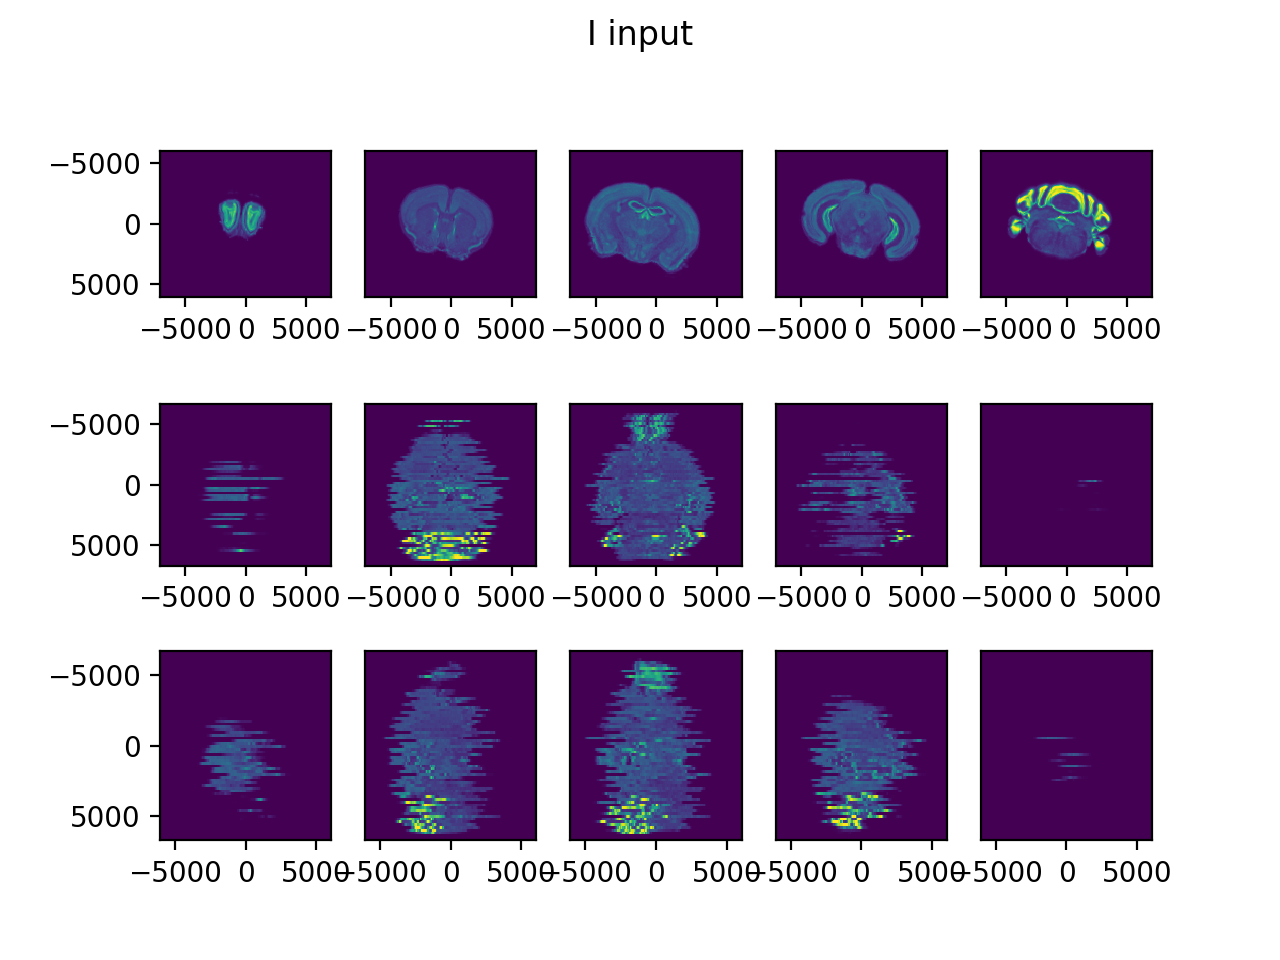

<IPython.core.display.Javascript object>


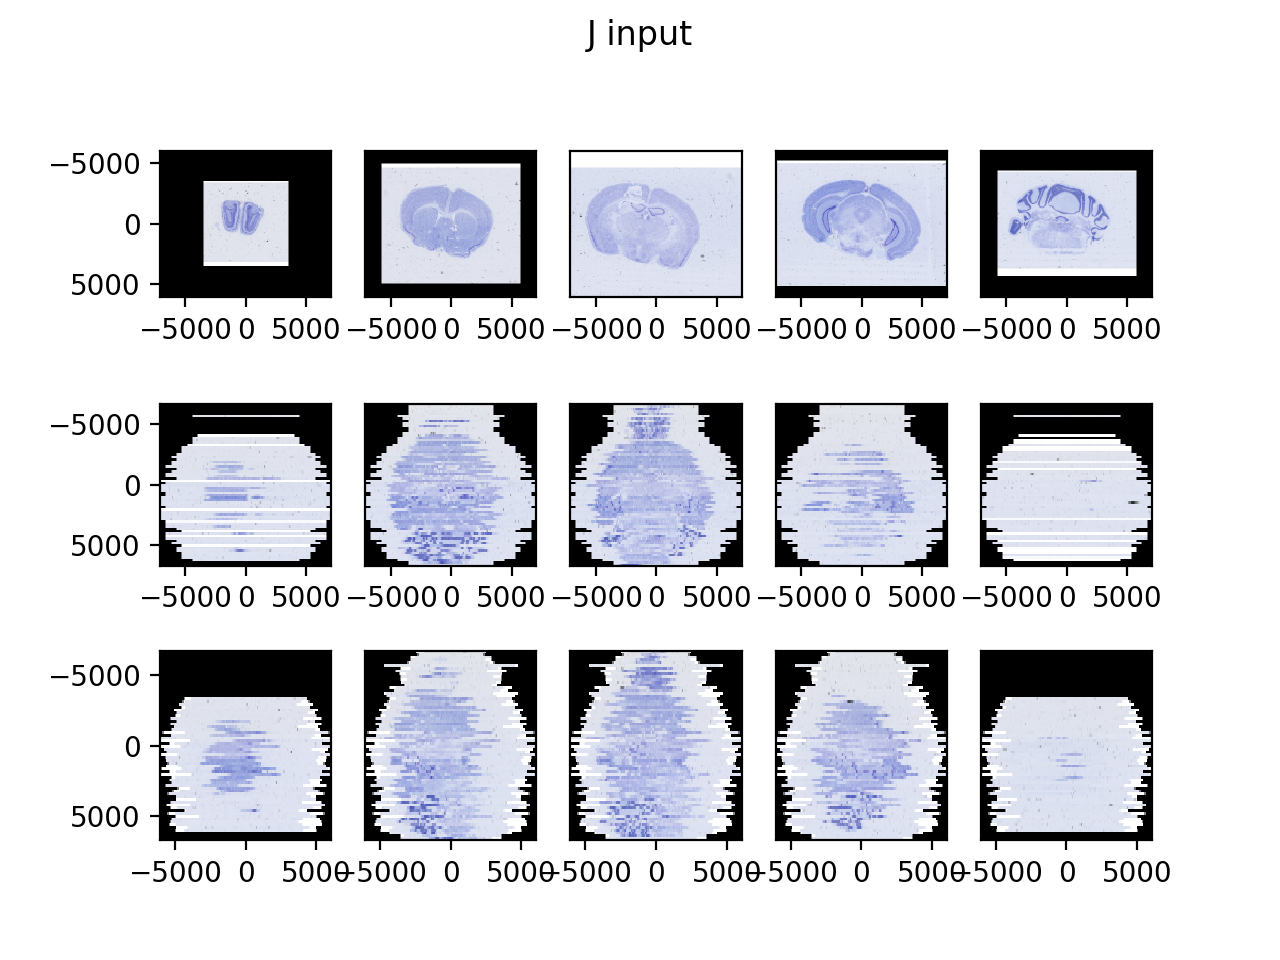

<IPython.core.display.Javascript object>


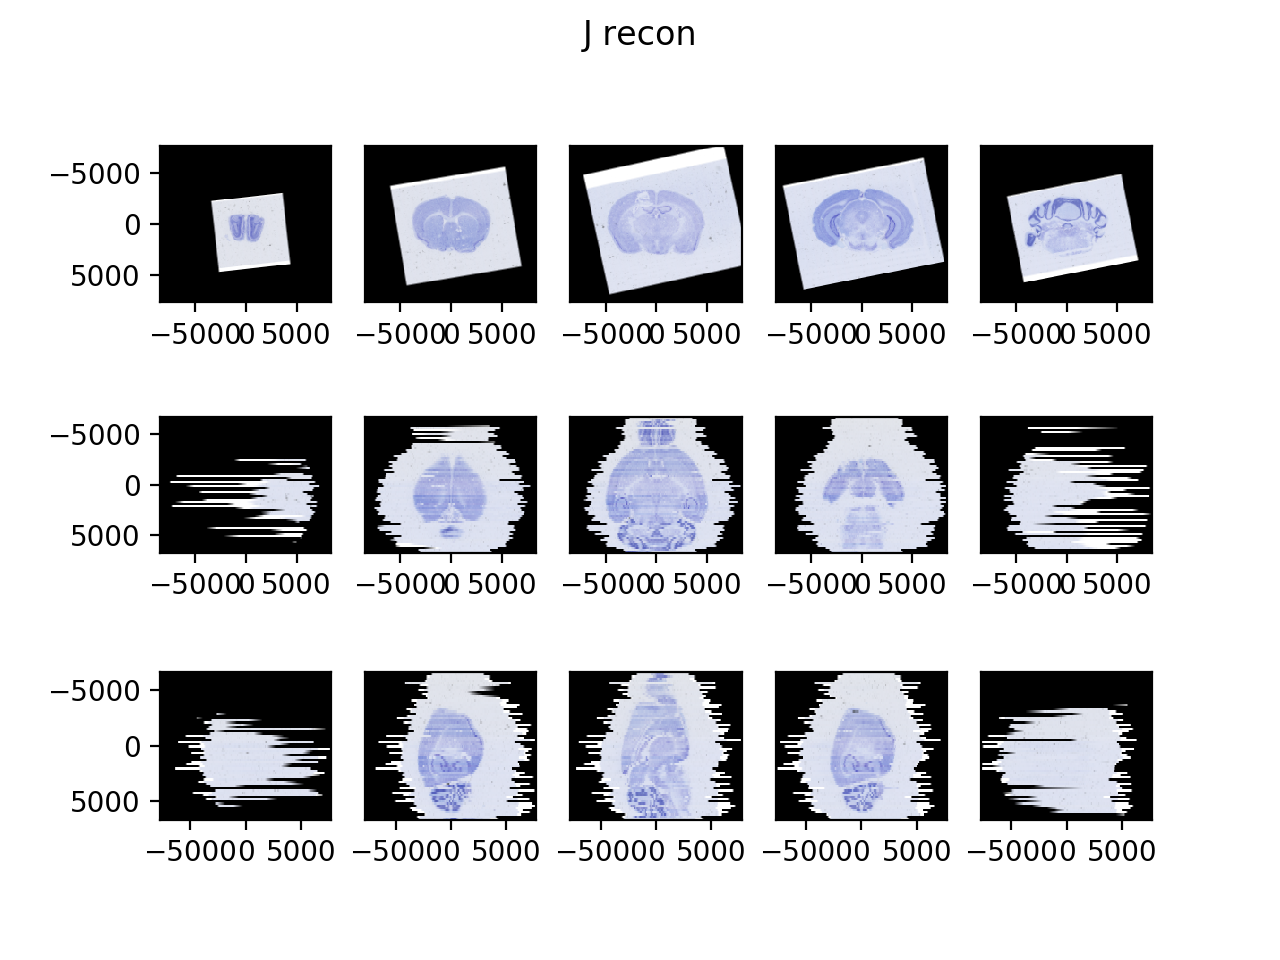

<IPython.core.display.Javascript object>


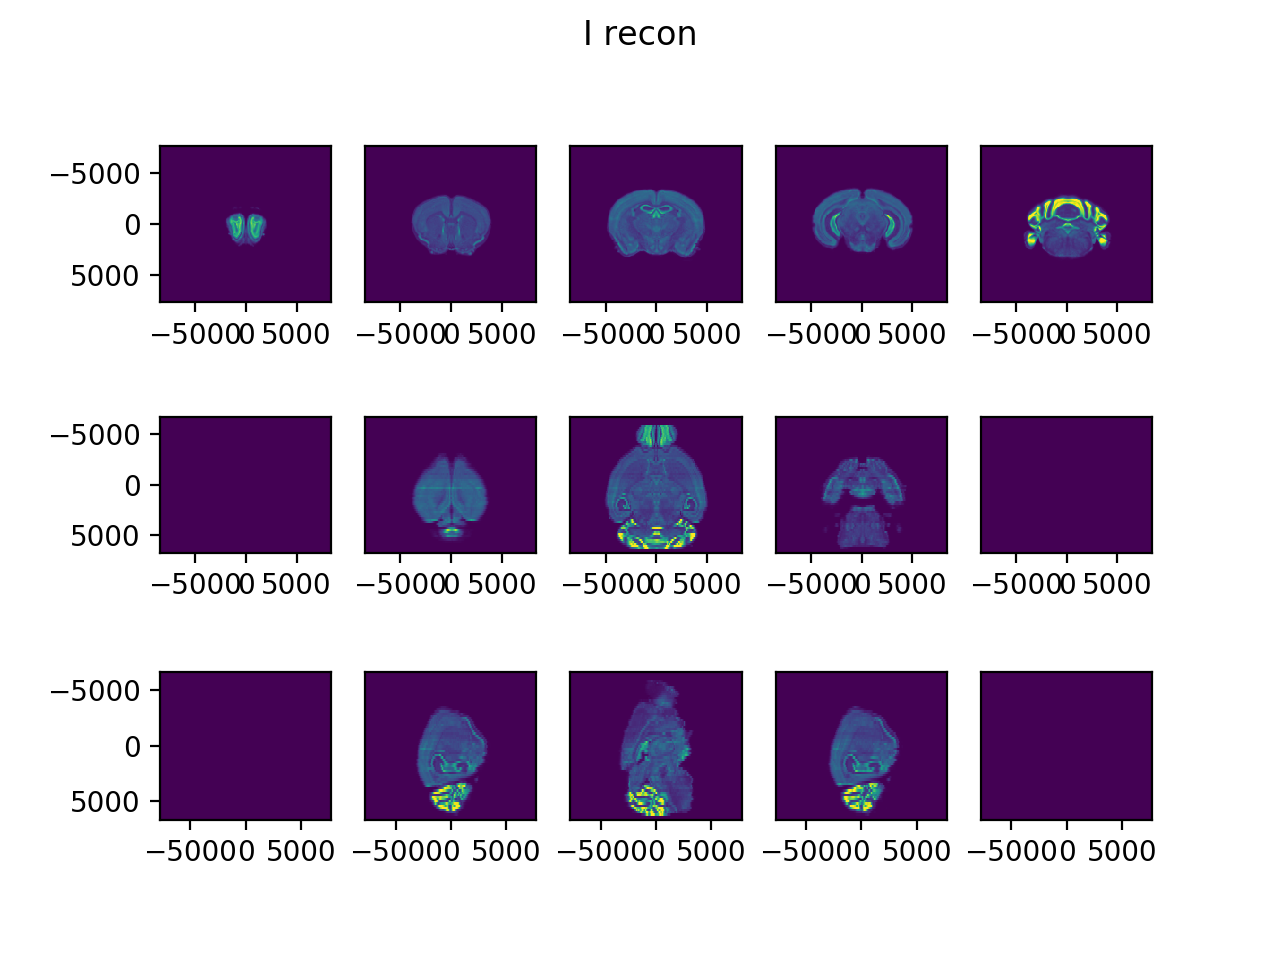

<IPython.core.display.Javascript object>


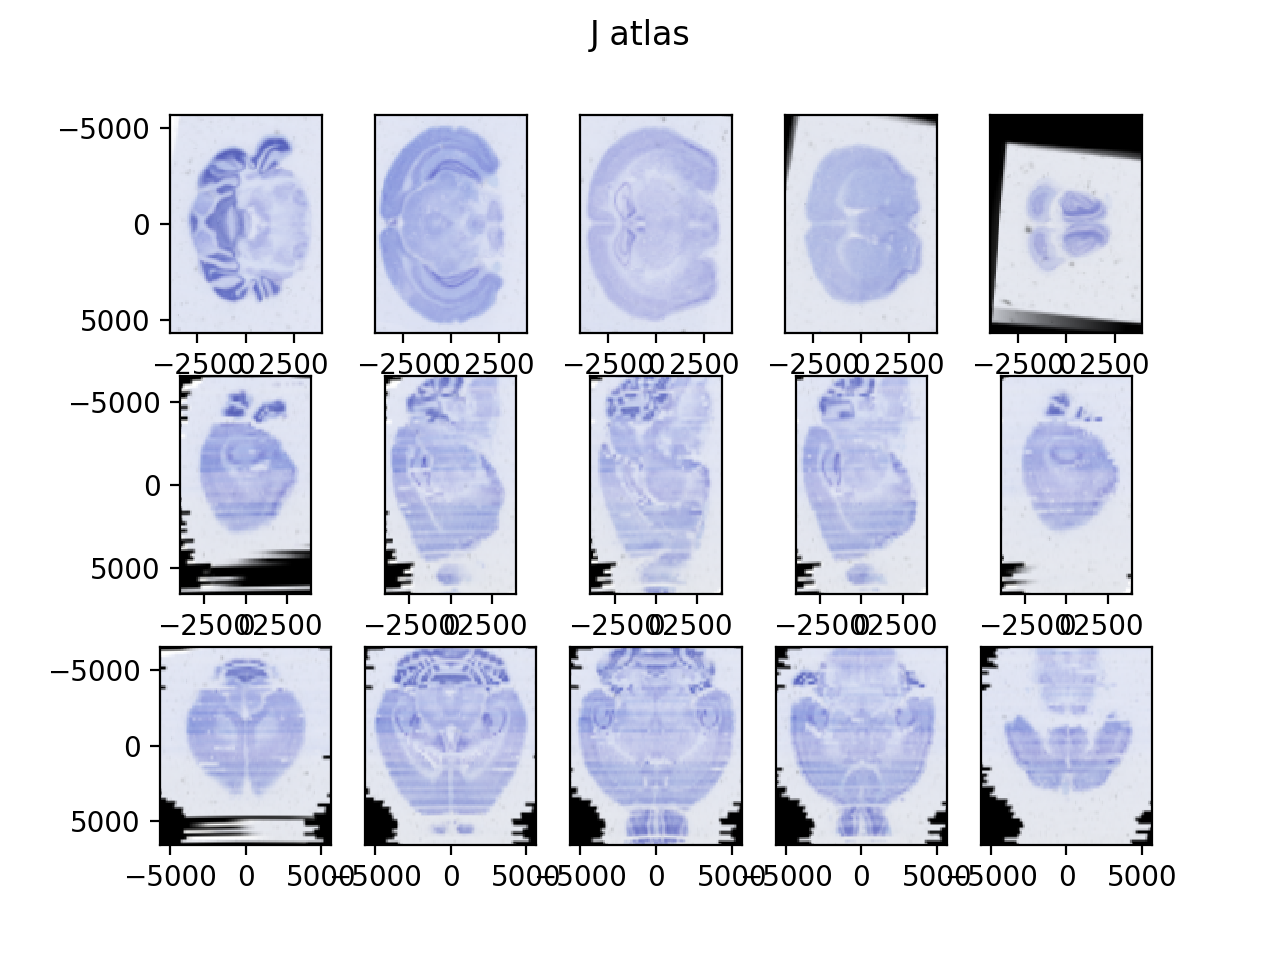

<IPython.core.display.Javascript object>


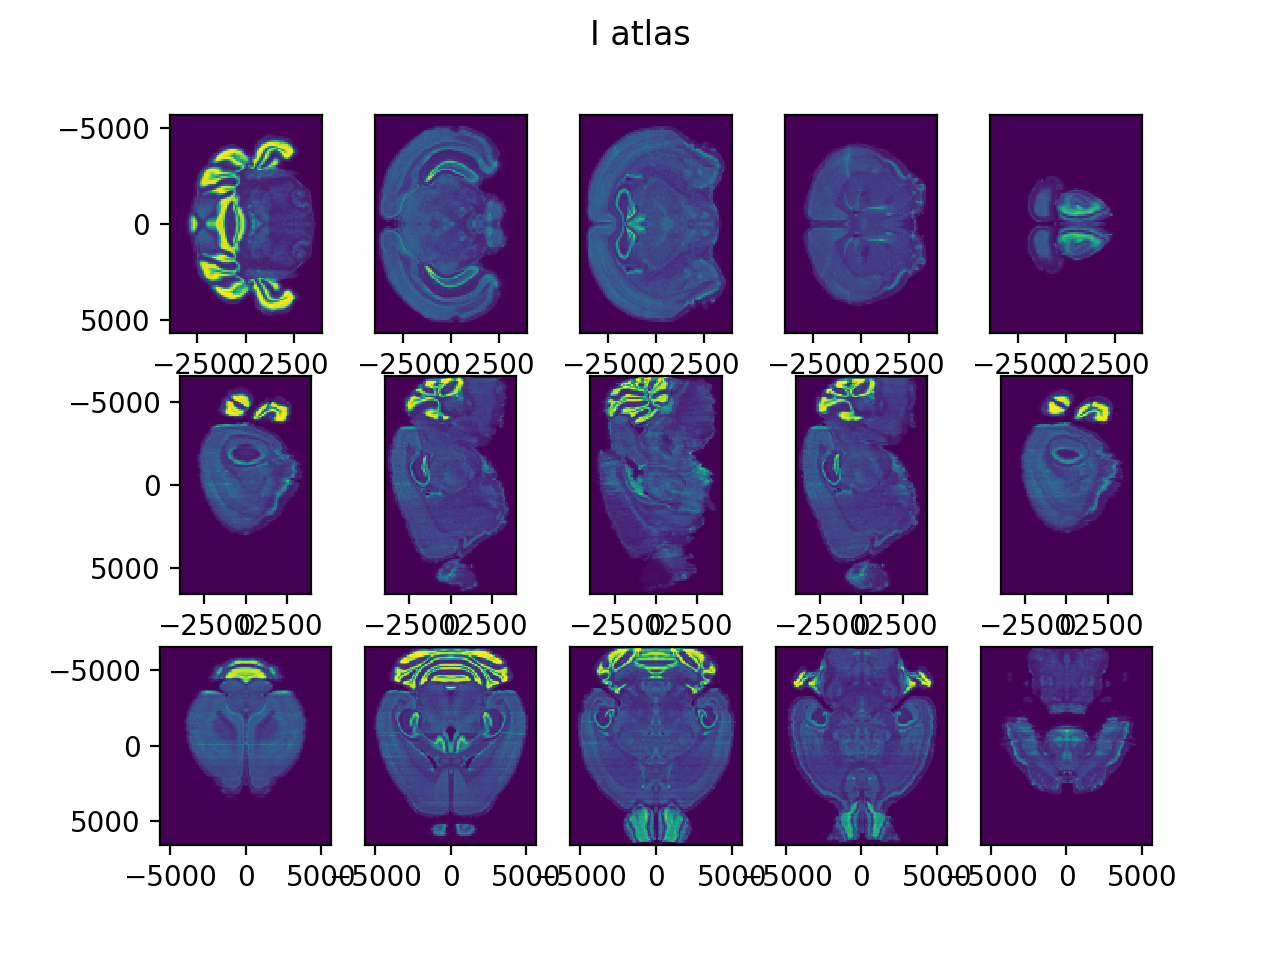

/mnt/data/csh_data/emlddmm/emlddmm.py:1848: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  AphiS = interp(xS,torch.tensor(S,device=device,dtype=dtype),phiiAi,mode='nearest').cpu().numpy()[0]


<IPython.core.display.Javascript object>


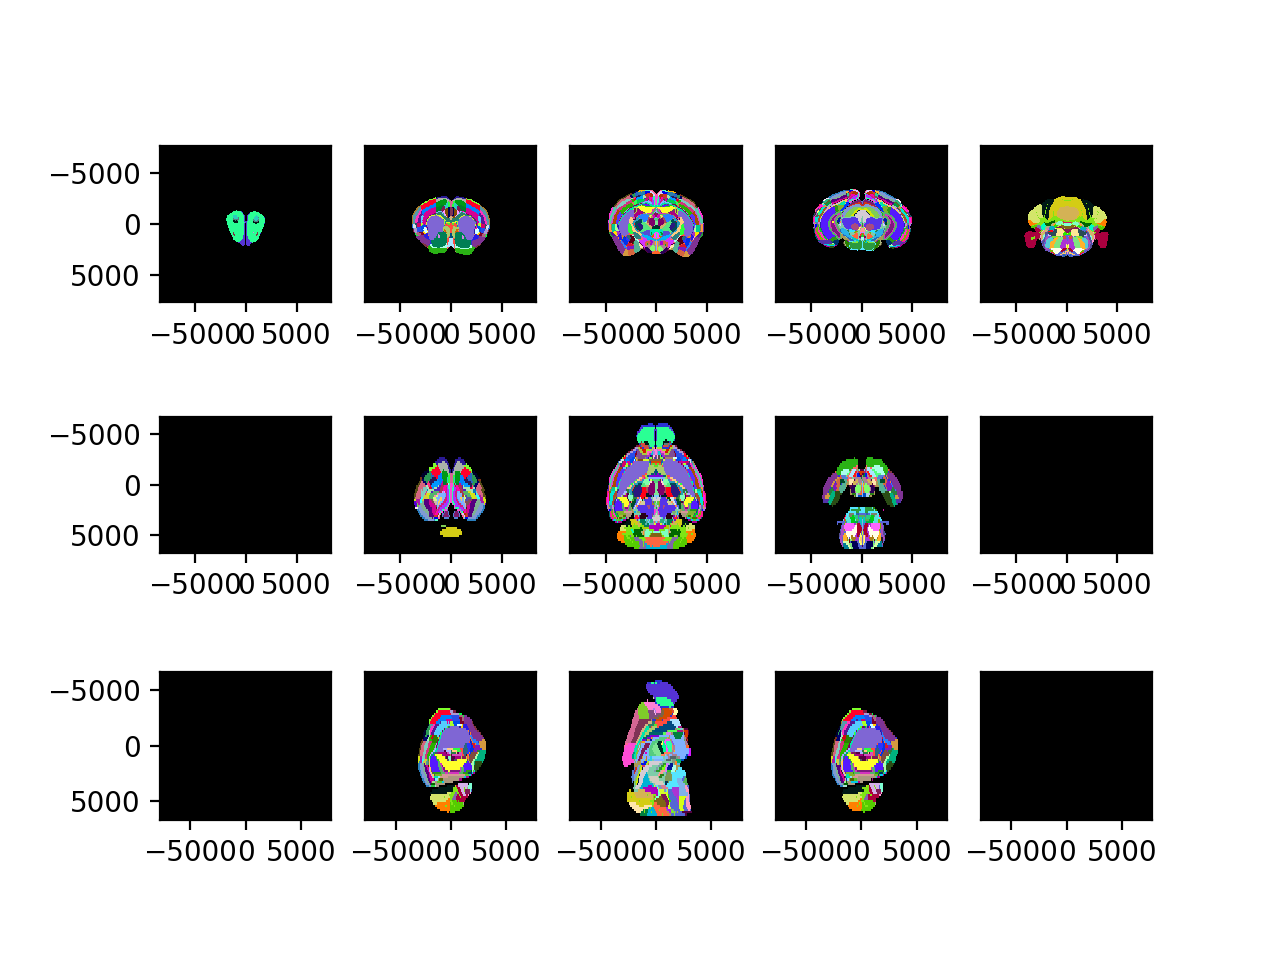

/mnt/data/csh_data/emlddmm/emlddmm.py:1883: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax = plt.subplots()


<IPython.core.display.Javascript object>


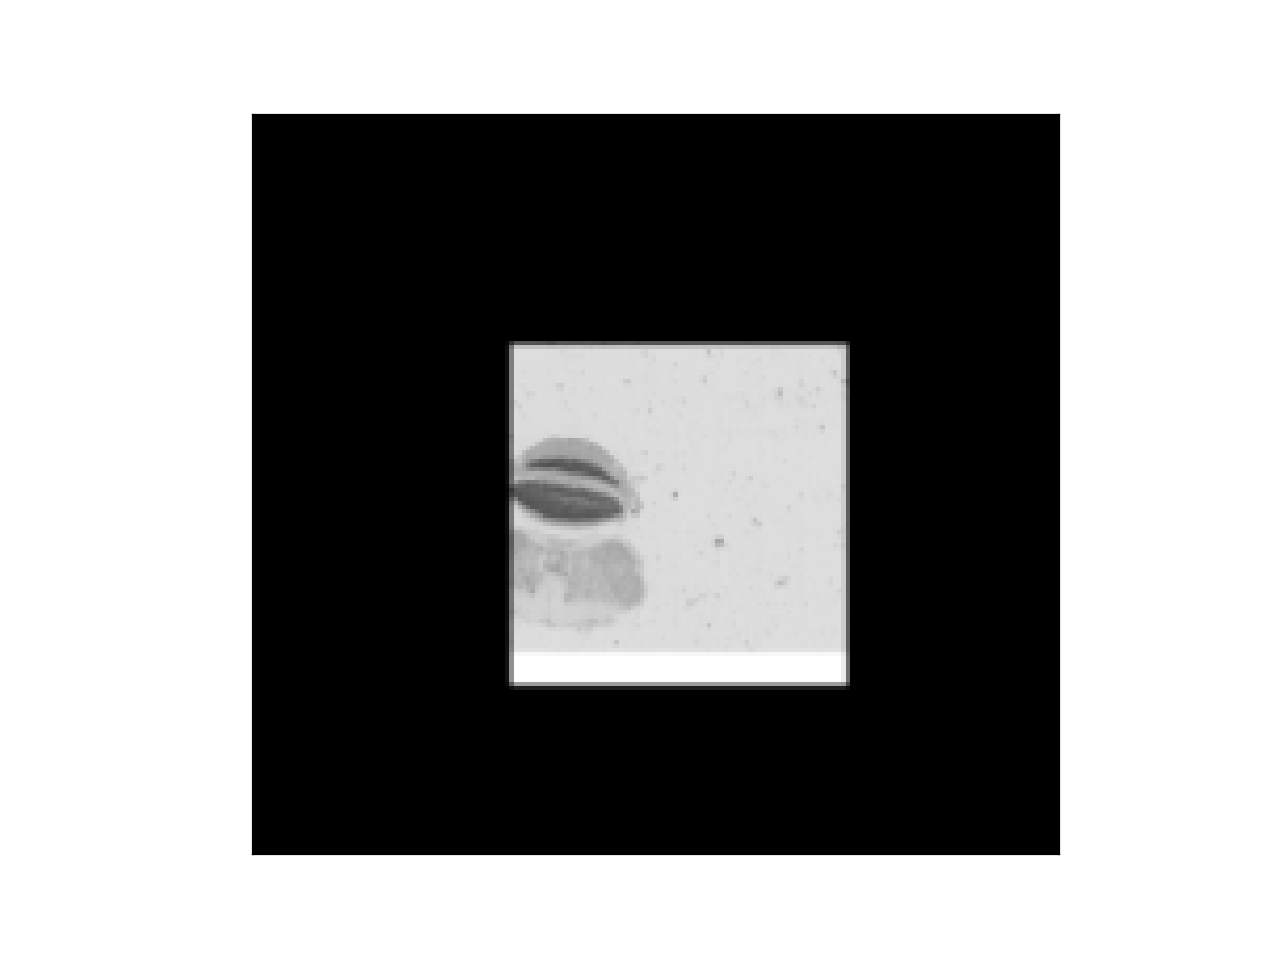

In [14]:
# get labels
imp.reload(emlddmm)
xS,S,title,names = emlddmm.read_data(label_name,endian='l')
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))